# Pipeline Notebook - Part 2

This notebook serves as the **main orchestrator** for training and evaluating different neural network architectures, including:

- **2D convolution neural networks for spectrograms (2DCNN spectrogram)**
- **Hybrid 2D convolution neural networks with Bidirectional Gated Recurrent Units (BiGRU) for spectrograms (2DCNN BiGRU - Hybrid spectrogram)**
- **2D convolution neural networks for scalograms (2DCNN scalogram)**
- **Hybrid 2D convolution neural networks with Bidirectional Gated Recurrent Units (BiGRU) for scalograms (2DCNN BiGRU - Hybrid scalogram)**

**Project Structure**  
The notebook integrates several Python modules for a modular and structured workflow:

- `libraries_utils.py` – Loads required libraries.  
- `code_methodo_2.py` – Defines **2DCNN spectrogram**, **2DCNN BiGRU - Hybrid spectrogram**, **2DCNN scalogram**, and **2DCNN BiGRU - Hybrid scalogram** architectures, along with other utilities for training neural networks.   
- `data_loader.py` – Handles data loading and preprocessing.  
- `functions_utils_for_nn.py` – Implements generators, training loops and inference functions.  
- `bootstrap_performances.py`, `regression_roc_auc.py`, `code_show_result.py` – Computes evaluation metrics for performance analysis.  

**Workflow**

1.Define hyperparameters and model configurations.  
2.Load and preprocess the dataset.  
3.Train the selected neural network model.  
4.Evaluate performance using predefined metrics.  
5.Visualize results and insights.  

This notebook ensures a structured and reproducible workflow for training and evaluating deep learning models on temporal and sequential data.

## Import Modules

In [1]:
#Use sys.getsizeof to get the size of an object, in bytes.
import sys
from sys import getsizeof

#%whos ou who -> to view defined variables
#getsizeof(tr_data) -> to see the variable size in number of bytes

import warnings
warnings.filterwarnings("ignore")

In [2]:
from libraries_utils import *
from code_methodo_2 import *
from bootstrap_performances import *
from data_loader import *
from regression_roc_auc import *
from functions_utils_for_nn import * # check avec cette fonction sur les anophèle âge... plus tard -> fichier importé grâce à code_methodo.py car import dans le fichier
from code_show_result import *

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5c3b83a950>: Failed to establish a new connection: [Errno -2] Name or service not known'))
2025-02-02 21:47:24.816698: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-02 21:47:24.816768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-02 21:47:24.816810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 21:47:24.827469: I tensorflow/core/platf

TensorFlow version:  2.14.0

Packages:
	keras.backend as K
	tensorflow.keras.layers import Layer
	keras import initializers, regularizers, constraints
    numpy as np

Functions:
    remove_files_in_folder
	ajout_colonne_anatomie_3_classes
	ajout_colonne_anatomie
	fusionner_espece
	f1_metric
	recall_m
    precision_m
    f1_m
    convert_sparse_matrix_to_sparse_tensor
    nn_batch_generator
    batch_generator
    new_my_batch_generator_timestep
    new_my_batch_generator_for_test_timestep
    class Attention
    generate_class_weights
    transform_spectrogram
    class fm_cwt_transform_into_scalogramm
    class fm_transform_into_image
    compute_wavelet_features
    batch_generator_for_scalo_image
    batch_generator_for_scalo_image_test




## 🤚 Note for readers :


### 👉For Dataset Title : 
- Pauline is referring to the **Senegal 1** dataset.  
  *(The other dataset, "Noémie," was tested during execution, but preprocessing was not done properly for some models as part of an internal check. Therefore, we do not consider this one.)*  


- For the **Anopheles age and Anopheles species datasets**: 
    - P or PATTES refers to **Legs**, 
    - T or TETE refers to the **Head**
    - TH or THORAX refers to the **Thorax** anatomical part.  
    

- For MABS dataset : **all** is just referring for one run to make the classication of 2 or 3 classes.  


### 👉Notes on Results:
The results presented in this notebook may differ by **approximately 1%** from those reported in the article. This discrepancy arises because, in the article, the reported values were rounded up to the nearest decimal.

Additionally, for some models, we conducted a second run due to either an incorrect batch size selection or an execution interruption. In general, the results selected for the article are explicitly mentioned.


### 👉 Notes on Re-executions:
Due to an accidental deletion of certain results and runs when importing the notebook, some models had to be retrained. Fortunately, all execution details were recorded in Excel and document files, preserving the original information.

As a result, the new runs may exhibit slight variations compared to the article, with differences of only a few percentage points. However, this does not impact the overall model performance, and in some cases, the new results are even better than those previously published.

These re-executions were carried out to accurately document the methodology and workflow followed throughout the project.



# Results Table Initialization and Global Variable Setup

In [3]:
VALIDATION_ACCURACY = []
VALIDATION_F1_SCORE = []
VALIDATION_LOSS = []

TEST_ACCURACY , TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION , TEST_F1_SCORE, TEST_CM, TEST_BOOTSTRAP, TEST_ROC_AUC, TEST_R2_SCORE = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_MAE, TEST_ACC_BY_CAT = collections.defaultdict(list), collections.defaultdict(list)

fold_var = 0


Stock_pred = []
Stock_target = []
Stock_index = []

In [4]:
len_sp = 4000 #global variable

# CNN 2 dimension - Wavelet

In [9]:
#len_sp = 4000
def run_model_cnn2d_scalo(data_name, model_name):
    
    if data_name == 'MABSC_coh_espece':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_basl_interp_5'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        feature_of_stratification = 'souche'
        colonne = 'Intensite baseline als interp reduc 5'
        target = 'espece'
        number_class = 3
        EPOCH = 25
        BATCH = 64
        types = 'classification'

        start = timeit.default_timer()
        

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()

        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_espece = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_espece)

        bootstrap_collect_espece = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_espece)

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")

        essaie.clean_model_session()
        return tableau_perf_espece, bootstrap_collect_espece
    
    elif data_name == 'MABSC_coh_resistance':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_basl_interp_5'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        data_train['resistance'] = data_train.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        data_test['resistance'] = data_test.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        feature_of_stratification = 'souche'
        colonne = 'Intensite baseline als interp reduc 5'
        target = 'resistance'
        number_class = 2
        EPOCH = 25
        BATCH = 64
        types = 'classification'

        start = timeit.default_timer()
        

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()

        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_resistance = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_resistance)
        
        bootstrap_collect_resistance = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_resistance)

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")

        essaie.clean_model_session()
        
        return tableau_perf_resistance, bootstrap_collect_resistance
    
    
    elif data_name == 'Anophele_age':
        print("DATA : ", data_name )
        type_data_name = 'Intensite_basl_interp_5'
        data_train, test_pauline, test_noemie = more_data_uploading(data_name, type_data_name)
        
        data_train['regression'] = data_train.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_pauline['regression'] = test_pauline.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_noemie['regression'] = test_noemie.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        
        data_train['Partie anatomique'] = data_train.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_pauline['Partie anatomique'] = test_pauline.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_noemie['Partie anatomique'] = test_noemie.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite baseline als interp reduc 5'
        target = 'regression'
        number_class = 1
        EPOCH = 25
        BATCH = 16 #16 for legs and thorax and 32 for head for hybrid model #64 for non hybrid model all anatomical part
        types = 'regression'

        start = timeit.default_timer()
        
        tableau_perf_pauline_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_pauline_all = collections.defaultdict(list)
        tableau_perf_noemie_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_noemie_all = collections.defaultdict(list)

        for part_anatom in ['TH']: #'P', 'T',
            train = data_train[data_train['Partie anatomique']==part_anatom]
            train = train.reset_index(drop=True)

            tst_pauline = test_pauline[test_pauline['Partie anatomique']==part_anatom]
            tst_pauline = tst_pauline.reset_index(drop=True)
            tst_noemie = test_noemie[test_noemie['Partie anatomique']==part_anatom]
            tst_noemie = tst_noemie.reset_index(drop=True)

            essaie = Methodology_models(model_name, len_sp, number_class)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data_pauline, y_tst_data_pauline = essaie.data_preparation_zero_shot_test(tst_pauline, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            tst_data_noemie, y_tst_data_noemie = essaie.data_preparation_zero_shot_test(tst_noemie, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            del train, tst_pauline, tst_noemie

            tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
            tracker.epoch_start()
            
            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test_pauline = essaie.model_predict(tst_data_pauline, y_tst_data_pauline, types)
            tableau_perf_pauline = performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(tableau_perf_pauline)
            for el, el_update in zip(tableau_perf_pauline, tableau_perf_pauline_all):
                el_update.update(el)
            
            bootstrap_collect_pauline = bootstrap_performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(bootstrap_collect_pauline)
            bootstrap_collect_pauline_all.update(bootstrap_collect_pauline)

            essaie_compile_y_test_noemie = essaie.model_predict(tst_data_noemie, y_tst_data_noemie, types)
            tableau_perf_noemie = performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(tableau_perf_noemie)
            for el, el_update in zip(tableau_perf_noemie, tableau_perf_noemie_all):
                el_update.update(el)
            
            bootstrap_collect_noemie = bootstrap_performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(bootstrap_collect_noemie)
            bootstrap_collect_noemie_all.update(bootstrap_collect_noemie)

            tracker.epoch_end()
            tracker.stop()
            
            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]
            
            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
            
            
            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")
            
            print("#######################################################################################")
            
            stop = timeit.default_timer()
    
            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")
            
            essaie.clean_model_session()

            del tr_data, y_tr_data, va_data, y_va_data, tst_data_pauline, y_tst_data_pauline, tst_data_noemie, y_tst_data_noemie
            
        
        return tableau_perf_pauline_all, bootstrap_collect_pauline_all, tableau_perf_noemie_all, bootstrap_collect_noemie_all
    
    
    elif data_name == 'Anophele_identif':
        print("DATA : ", data_name )
        type_data_name = 'Intensite_basl_interp_5'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        
        data_train = data_train[~data_train.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        data_test = data_test[~data_test.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite baseline als interp reduc 5'
        target = 'espece'
        number_class = 4
        EPOCH = 25
        BATCH = 64 #32 #64
        types = 'classification'

        start = timeit.default_timer()
        
        
        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)

        for part_anatom in ['PATTES']: #'PATTES',, 'THORAX'
            train = data_train[data_train['anatom']==part_anatom] 
            train = train.reset_index(drop=True)

            tst = data_test[data_test['anatom']==part_anatom] 
            tst = tst.reset_index(drop=True)

            essaie = Methodology_models(model_name, len_sp, number_class)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(tst, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)


            del train, tst

            tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
            tracker.epoch_start()

            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)
            
            tableau_perf = performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(tableau_perf)
            for el, el_update in zip(tableau_perf, tableau_perf_all):
                el_update.update(el)
        
            bootstrap_collect = bootstrap_performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(bootstrap_collect)
            bootstrap_collect_all.update(bootstrap_collect)

            tracker.epoch_end()
            tracker.stop()
            
            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]
            
            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
            
            
            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")
            
            print("#######################################################################################")
            
            stop = timeit.default_timer()
    
            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")

            essaie.clean_model_session()
            
            del tr_data, y_tr_data, va_data, y_va_data, tst_data, y_tst_data
            
            
        return tableau_perf_all, bootstrap_collect_all
    
    
    
    else :
        raise ValueError("Data name unknown")
        

## CNN2D Hybrid Scalogram : Anopheles age and MABS

DATA :  Anophele_age


2025-02-02 21:47:44.097071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5bac2c7f70>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 78, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 152, 153, 155, 156, 157, 159, 160, 161, 163, 164, 165, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178] size :  144
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17,

2025-02-02 21:47:49.472250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-02-02 21:47:51.789459: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5b3ed95300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 21:47:51.789515: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2025-02-02 21:47:51.799923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-02 21:47:51.948859: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - 61s 2s/step - loss: 8.4115 - mae: 8.9038 - val_loss: 7.5118 - val_mae: 8.0118
Epoch 2/25
35/35 [==============================] - 55s 2s/step - loss: 7.4746 - mae: 7.9578 - val_loss: 7.0960 - val_mae: 7.5960
Epoch 3/25
35/35 [==============================] - 58s 2s/step - loss: 6.8493 - mae: 7.3399 - val_loss: 6.1562 - val_mae: 6.6387
Epoch 4/25
35/35 [==============================] - 51s 2s/step - loss: 4.3007 - mae: 4.7735 - val_loss: 2.8488 - val_mae: 3.3039
Epoch 5/25
35/35 [==============================] - 51s 1s/step - loss: 2.2624 - mae: 2.6877 - val_loss: 2.4875 - val_mae: 2.9477
Epoch 6/25
35/35 [==============================] - 51s 1s/step - loss: 1.7944 - mae: 2.2103 - val_loss: 2.1369 - val_mae: 2.5936
Epoch 7/25
35/35 [==============================] - 48s 1s/step - loss: 1.6862 - mae: 2.0975 - val_loss: 2.3110 - val_mae: 2.7303
Epoch 8/25
35/35 [==============================] - 50s 1s/step - loss: 1.4321 - mae: 1.8300 - val_lo

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5b1b3eac50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

35/35 [==============================] - 48s 1s/step - loss: 0.2943 - mae: 0.5930 - val_loss: 1.6471 - val_mae: 2.0539
Epoch 19/25
35/35 [==============================] - 48s 1s/step - loss: 0.2256 - mae: 0.5094 - val_loss: 2.0134 - val_mae: 2.4291
Epoch 20/25
35/35 [==============================] - 50s 1s/step - loss: 0.3007 - mae: 0.6102 - val_loss: 1.7202 - val_mae: 2.1580
Epoch 20: early stopping
7/7 [==============================] - 8s 1s/step - loss: 1.6546 - mae: 2.0677


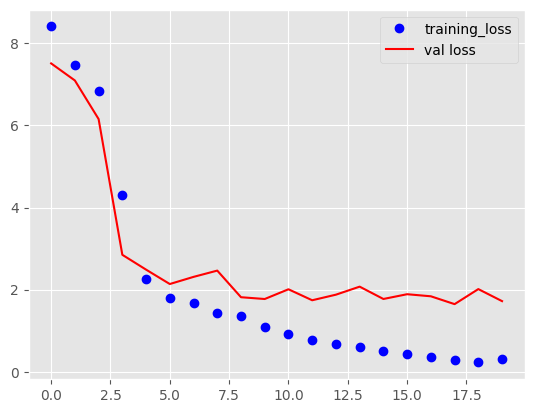

117/117 [==============================] - 8s 64ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  3.4451306,  2.3958237,
        2.6822584,  4.0146194,  2.5328307,  2.0505724,  2.5767272,
        4.0172853,  1.6809549,  5.536108 ,  2.674275

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5b19024130>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.009416, 'mean': 8.046194, 'med': 8.051015, 'q1': 6.523457884788513, 'q3': 9.60298957824707, 'whislo': 5.4839077, 'whishi': 10.727228}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:17:48
	Energy:	0.033788359219 kWh
	CO2eq:	16.049470629026 g
	This is equivalent to:
	0.149297401200 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5b19025060>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	14:50:07
	Energy:	1.689417960950 kWh
	CO2eq:	802.473531451315 g
	This is equivalent to:
	7.464870060012 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/3654365_2025-02-02T214744Z_carbontracker_output.log
S

In [10]:
#02/02/25
model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_cnn2d_scalo('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Senegal 1", position = 0)


del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP

In [11]:
#02/02/25
display(df_res_anophele_pauline)

,TH
Metrics,
Test MAE,2.07
,"[1.74,2.43]"
Roc AUC score,0.95
,"[0.93,0.97]"
R2 score,0.89


DATA :  Anophele_age


2025-02-02 20:56:18.799113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fcf4f9c9540>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 149, 151, 152, 153, 155, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182] size :  147
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

2025-02-02 20:56:25.374632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-02-02 20:56:27.661460: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fce30acb160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 20:56:27.661525: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2025-02-02 20:56:27.670867: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-02 20:56:27.831943: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 65s 3s/step - loss: 8.2213 - mae: 8.7060 - val_loss: 8.0689 - val_mae: 8.5668
Epoch 2/25
18/18 [==============================] - 57s 3s/step - loss: 7.6028 - mae: 8.0955 - val_loss: 7.6670 - val_mae: 8.1328
Epoch 3/25
18/18 [==============================] - 52s 3s/step - loss: 7.3213 - mae: 7.8166 - val_loss: 7.2303 - val_mae: 7.7125
Epoch 4/25
18/18 [==============================] - 51s 3s/step - loss: 7.5352 - mae: 8.0027 - val_loss: 6.7852 - val_mae: 7.2851
Epoch 5/25
18/18 [==============================] - 52s 3s/step - loss: 7.2119 - mae: 7.7046 - val_loss: 6.9299 - val_mae: 7.4299
Epoch 6/25
18/18 [==============================] - 52s 3s/step - loss: 6.7261 - mae: 7.2194 - val_loss: 6.4939 - val_mae: 6.9662
Epoch 7/25
18/18 [==============================] - 53s 3s/step - loss: 6.5514 - mae: 7.0398 - val_loss: 5.4430 - val_mae: 5.9266
Epoch 8/25
18/18 [==============================] - 52s 3s/step - loss: 4.9886 - mae: 5.4791 - val_lo

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fce5cb743a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

18/18 [==============================] - 51s 3s/step - loss: 1.1816 - mae: 1.5517 - val_loss: 2.0739 - val_mae: 2.4945
Epoch 18/25
18/18 [==============================] - 52s 3s/step - loss: 0.9402 - mae: 1.2989 - val_loss: 1.9759 - val_mae: 2.3877
Epoch 19/25
18/18 [==============================] - 52s 3s/step - loss: 0.7691 - mae: 1.1212 - val_loss: 1.8899 - val_mae: 2.3066
Epoch 20/25
18/18 [==============================] - 54s 3s/step - loss: 0.6751 - mae: 1.0239 - val_loss: 1.9463 - val_mae: 2.3452
Epoch 20: early stopping
7/7 [==============================] - 14s 2s/step - loss: 2.0706 - mae: 2.4926


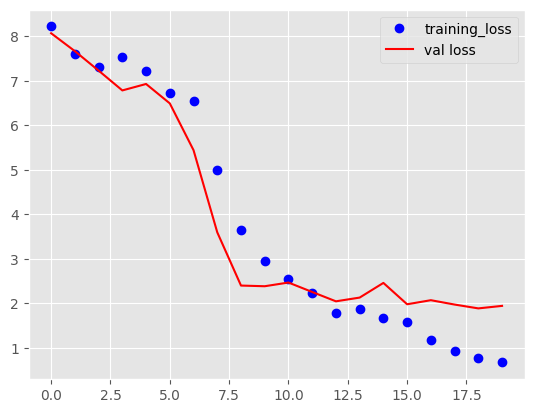

124/124 [==============================] - 9s 64ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 0.07822017,  0.96725684,  2.9253795 ,  0.        ,  0.4941546 ,
        1.2862617 ,  7.095788  ,  2.7921789 ,  4.567614  ,  1.8712219 ,
        1.8902411 ,  3.0430045 ,  1.5600307 ,  3.024959  ,  2.5226629 ,
 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fce481420e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.133009, 'mean': 8.112108, 'med': 8.090139, 'q1': 6.842611074447632, 'q3': 9.512422966957093, 'whislo': 5.9214683, 'whishi': 10.279805}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:19:18
	Energy:	0.036643120766 kWh
	CO2eq:	17.405482363614 g
	This is equivalent to:
	0.161911463848 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fce481421a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	16:05:11
	Energy:	1.832156038275 kWh
	CO2eq:	870.274118180686 g
	This is equivalent to:
	8.095573192378 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/3644027_2025-02-02T204709Z_carbontracker_output.log
S

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fce5cb5c280>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 75, 75, 3)]    0         
                     

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fce49c8dc00>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

17/17 [==============================] - 52s 3s/step - loss: 12.2647 - mae: 12.6949 - val_loss: 12.3242 - val_mae: 12.7656
Epoch 19/25
17/17 [==============================] - 49s 3s/step - loss: 12.0551 - mae: 12.4853 - val_loss: 12.

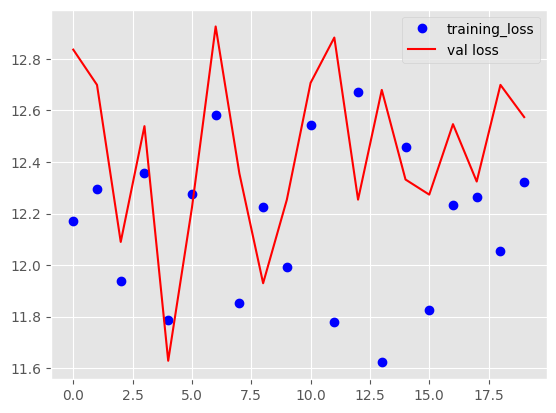

117/117 [==============================] - 8s 66ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0

In [ ]:
#02/02/25
model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_cnn2d_scalo('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Senegal 1", position = 0)


del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP

In [17]:
#02/02/25
display(df_res_anophele_pauline)

,T
Metrics,
Test MAE,2.93
,"[2.5,3.41]"
Roc AUC score,0.90
,"[0.87,0.93]"
R2 score,0.78


DATA :  Anophele_age


2025-02-02 19:44:39.964994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe2a06a3f70>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10

2025-02-02 19:44:45.301973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-02-02 19:44:47.656815: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe238a0bfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 19:44:47.656869: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2025-02-02 19:44:47.665034: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-02 19:44:47.808110: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 68s 2s/step - loss: 7.4765 - mae: 7.9682 - val_loss: 6.9521 - val_mae: 7.4463
Epoch 2/25
40/40 [==============================] - 60s 2s/step - loss: 7.1154 - mae: 7.6076 - val_loss: 6.7842 - val_mae: 7.2842
Epoch 3/25
40/40 [==============================] - 62s 2s/step - loss: 5.1918 - mae: 5.6777 - val_loss: 2.9321 - val_mae: 3.3519
Epoch 4/25
40/40 [==============================] - 61s 2s/step - loss: 2.4744 - mae: 2.8952 - val_loss: 3.4640 - val_mae: 3.9068
Epoch 5/25
40/40 [==============================] - 54s 1s/step - loss: 1.8953 - mae: 2.3154 - val_loss: 2.4630 - val_mae: 2.9128
Epoch 6/25
40/40 [==============================] - 58s 1s/step - loss: 1.5339 - mae: 1.9337 - val_loss: 2.4579 - val_mae: 2.8976
Epoch 7/25
40/40 [==============================] - 57s 1s/step - loss: 1.2475 - mae: 1.6459 - val_loss: 2.3066 - val_mae: 2.7316
Epoch 8/25
40/40 [==============================] - 58s 1s/step - loss: 1.1781 - mae: 1.5695 - val_lo

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe250232c50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

40/40 [==============================] - 57s 1s/step - loss: 0.3245 - mae: 0.6337 - val_loss: 1.8912 - val_mae: 2.3120
Epoch 17/25
40/40 [==============================] - 60s 2s/step - loss: 0.2772 - mae: 0.5873 - val_loss: 1.7950 - val_mae: 2.2090
Epoch 18/25
40/40 [==============================] - 55s 1s/step - loss: 0.3080 - mae: 0.6169 - val_loss: 1.8833 - val_mae: 2.3226
Epoch 19/25
40/40 [==============================] - 57s 1s/step - loss: 0.2888 - mae: 0.5954 - val_loss: 1.8824 - val_mae: 2.3066
Epoch 20/25
40/40 [==============================] - 57s 1s/step - loss: 0.2158 - mae: 0.4937 - val_loss:

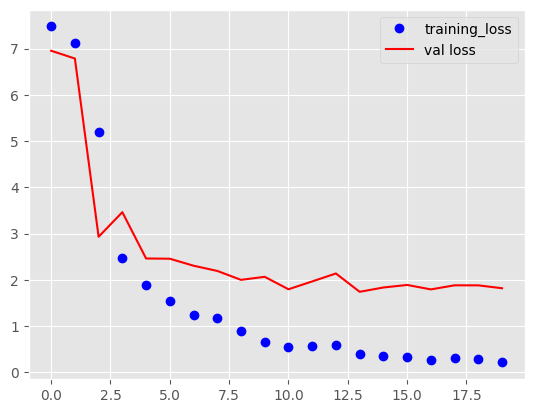

144/144 [==============================] - 10s 64ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.7825191,  0.       ,  0.2259858,  1.5223275,  1.252587 ,
        0.       ,  0.       ,  0. 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe214ba98a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 9.5889225, 'mean': 9.535691, 'med': 9.473715, 'q1': 7.460494899749756, 'q3': 11.718131780624388, 'whislo': 6.179253, 'whishi': 12.806462}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:20:14
	Energy:	0.038683529638 kWh
	CO2eq:	18.374676578168 g
	This is equivalent to:
	0.170927223983 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe214ba9690>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	16:51:21
	Energy:	1.934176481912 kWh
	CO2eq:	918.733828908394 g
	This is equivalent to:
	8.546361199148 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/3458947_2025-02-01T195027Z_carbontracker_output.log
S

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe250103190>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe214ecc5b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

9/9 [==============================] - 55s 7s/step - loss: 11.8116 - mae: 12.2448 - val_loss: 11.4297 - val_mae: 11.8672
Epoch 18/25
9/9 [==============================] - 55s 7s/step - loss: 12.1493 - mae: 12.5764 - val_loss: 11.9688

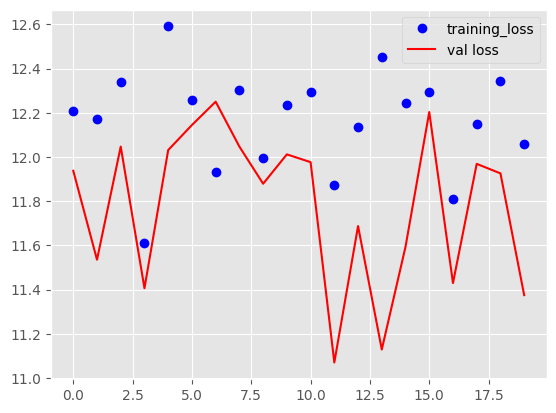

124/124 [==============================] - 8s 63ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe253c67790>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 12.615385, 'mean': 12.644558, 'med': 12.60577, 'q1': 10.441826701164246, 'q3': 15.076923370361328, 'whislo': 9.269231, 'whishi': 17.076923}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontra

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe253c67790>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe2502b5d50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationErro

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe2a0824e80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

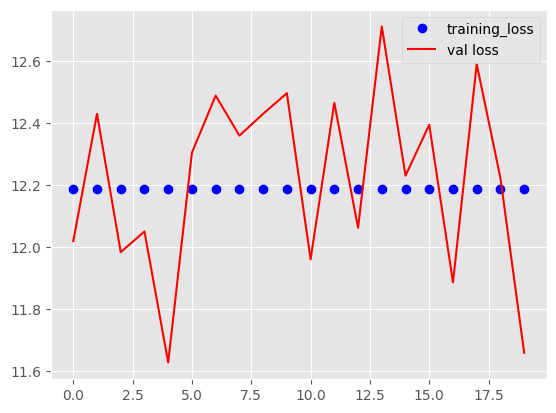

117/117 [==============================] - 11s 64ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe253292bf0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 12.384615, 'mean': 12.457058, 'med': 12.442307, 'q1': 10.057692527770996, 'q3': 15.03942322731018, 'whislo': 8.538462, 'whishi': 16.596153}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontr

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe253293130>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [10]:
#02/02/25

model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_cnn2d_scalo('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Senegal 1", position = 0)


del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP



In [11]:
display(df_res_anophele_pauline) # wrong batch size for head and thorax so we try again for these anatomical part
#02/02/25

,P,T,TH
Metrics,,,
Test MAE,2.59,13.34,13.60
,"[2.23,2.96]","[11.79,14.8]","[11.94,15.13]"
Roc AUC score,0.92,0.50,0.50
,"[0.89,0.94]","[0.5,0.5]","[0.5,0.5]"
R2 score,0.81,-2.49,-2.41


DATA :  MABSC_coh_resistance


2023-10-09 00:00:06.439744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11464 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


Train label :  [0, 2, 4, 5, 7, 8, 9, 11, 14, 16, 19, 21, 22, 23, 24, 25, 27, 28, 31, 3, 6, 10, 13, 15, 17, 30, 32] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Val label :  [18, 20, 26, 29, 1, 12] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 1, 1]
Train data dimensions: (648, 4000), (648, 1)
Validation data dimensions: (166, 4000), (166, 1)


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7efc435149d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 75, 75, 3)]    0         
                                                                 
 time_distributed (TimeDist  (None, 9, 73, 73, 3)      84        
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 9, 71

2023-10-09 00:00:16.480392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-09 00:00:19.598217: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efc2c22e140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 00:00:19.598576: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-09 00:00:19.607537: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 00:00:19.851505: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 76s 7s/step - loss: 0.7145 - acc: 0.3781 - f1_m: 0.3781 - val_loss: 0.7149 - val_acc: 0.2500 - val_f1_m: 0.2500
Epoch 2/25
10/10 [==============================] - 59s 7s/step - loss: 0.7132 - acc: 0.3703 - f1_m: 0.3703 - val_loss: 0.7631 - val_acc: 0.2578 - val_f1_m: 0.2578
Epoch 3/25
10/10 [==============================] - 59s 7s/step - loss: 0.6876 - acc: 0.3609 - f1_m: 0.3609 - val_loss: 0.8714 - val_acc: 0.2344 - val_f1_m: 0.2344
Epoch 4/25
10/10 [==============================] - 60s 7s/step - loss: 0.5429 - acc: 0.6406 - f1_m: 0.6406 - val_loss: 1.8058 - val_acc: 0.2969 - val_f1_m: 0.2969
Epoch 5/25
10/10 [==============================] - 60s 7s/step - loss: 0.5235 - acc: 0.7953 - f1_m: 0.7953 - val_loss: 0.7714 - val_acc: 0.4297 - val_f1_m: 0.4297
Epoch 6/25
10/10 [==============================] - 60s 7s/step - loss: 0.3676 - acc: 0.8438 - f1_m: 0.8437 - val_loss: 0.9397 - val_acc: 0.6172 - val_f1_m: 0.6172
Epoch 7/25
10/10 [=========

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7efbf029fbb0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

10/10 [==============================] - 59s 7s/step - loss: 0.0010 - acc: 1.0000 - f1_m: 1.0000 - val_loss: 3.1689 - val_acc: 0.5547 - val_f1_m: 0.5547
Epoch 16/25
10/10 [==============================] - 60s 7s/step - loss: 0.0032 - acc: 1.0000 - f1_m: 1.0000 - val_loss: 3.4144 - val_acc: 0.6875 - val_f1_m: 0.6875
Epoch 17/25
10/10 [==============================] - 59s 7s/step - loss: 0.0044 - acc: 1.0000 - f1_m: 1.0000 - val_loss: 3.2864 - val_acc: 0.5703 - val_f1_m: 0.5703
Epoch 18/25
10/10 [==============================] - 59s 7s/step - loss: 0.0013 - acc: 1.0000 - f1_m: 1.0000 - val_loss: 3.6233 - val_

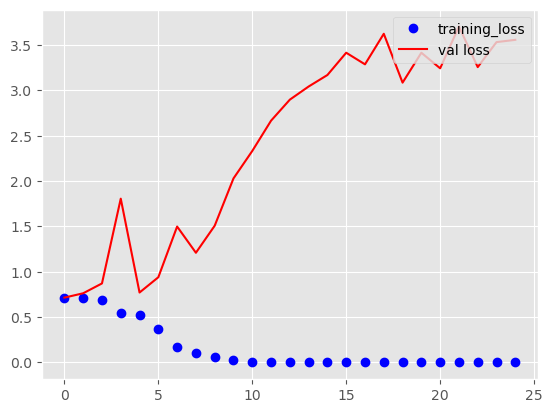

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 4000), (187, 1)
187/187 [==============================] - 13s 65ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7efbebe06980>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8823529411764706, 'mean': 0.8834064171122966, 'med': 0.8823529411764706, 'q1': 0.8342245989304813, 'q3': 0.93048128342246, 'whislo': 0.7807486631016043, 'whishi': 0.9518716577540107}, 'f1 all': {'main': 0.8107983811626196, 'mean': 0.8104875624401688, 'med': 0.8119288119288119, 'q1': 0.7361740286007168, 'q3': 0.8844856260394393, 'whislo': 0.6414877300613497, 'whishi': 0.9181778404394964}, 'recall all': {'main': 0.7659574468085106, 'mean': 0.7671183554709406, 'med': 0.7666666666666666, 'q1': 0.6976744186046512, 'q3': 0.8421463815789473, 'whislo': 0.6153846153846154, 'whishi': 0.881578947368421}, 'precision all': {'main': 0.9320987654320987, 'mean': 0.9327058969597193, 'med': 0.9333333333333333, 'q1': 0.9060551948051948, 'q3': 0.9583399681528662, 'whislo': 0.8779761904761905, 'whishi': 0.9715189873417722}, 'naive roc auc': {'main': 0.7659574468085106, 'mean': 0.7671183554709406, 'med': 0.7666666666666667, 'q1': 0.6976744186046512, 'q

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7efbebf2cfa0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	22:16:18
	Energy:	2.570753320025 kWh
	CO2eq:	1221.107827012058 g
	This is equivalent to:
	11.359142576856 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1140006_2023-10-09T000007Z_carbontracker_output.log

In [12]:
model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_cnn2d_scalo('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 2 resistance classification : R et S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [13]:
display(df_res_mabsc_resistance) #we keep this one and not the previous one

,all
Metrics,
Test accuracy,0.88
,"[0.83,0.93]"
Test balanced accuracy,0.76
,"[0.7,0.84]"
Mean F1 score,0.81
,"[0.74,0.88]"
F1 score by categories,[0.93 0.69]
Mean precision,0.93
,"[0.91,0.96]"


DATA :  MABSC_coh_espece


2023-10-08 23:03:51.713407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11464 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc82c0fa2f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 4000), (680, 1)
Validation data dimensions: (134, 4000), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
 Layer (type)   

2023-10-08 23:04:02.130862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 23:04:04.343323: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc7d4174c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 23:04:04.343363: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-08 23:04:04.352608: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 23:04:04.513849: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 77s 7s/step - loss: 1.0989 - categorical_accuracy: 0.3313 - f1_m: 0.0000e+00 - val_loss: 1.0693 - val_categorical_accuracy: 0.7891 - val_f1_m: 0.0000e+00
Epoch 2/25
10/10 [==============================] - 59s 7s/step - loss: 0.9813 - categorical_accuracy: 0.5266 - f1_m: 0.2060 - val_loss: 0.9874 - val_categorical_accuracy: 0.4766 - val_f1_m: 0.0000e+00
Epoch 3/25
10/10 [==============================] - 59s 7s/step - loss: 0.7701 - categorical_accuracy: 0.6344 - f1_m: 0.5193 - val_loss: 0.6763 - val_categorical_accuracy: 0.6172 - val_f1_m: 0.6302
Epoch 4/25
10/10 [==============================] - 59s 7s/step - loss: 0.6521 - categorical_accuracy: 0.7437 - f1_m: 0.6935 - val_loss: 0.6307 - val_categorical_accuracy: 0.6875 - val_f1_m: 0.7278
Epoch 5/25
10/10 [==============================] - 59s 7s/step - loss: 0.3335 - categorical_accuracy: 0.8969 - f1_m: 0.8846 - val_loss: 0.5584 - val_categorical_accuracy: 0.7578 - val_f1_m: 0.7375
Epoch 6/2

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7d847e950>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

10/10 [==============================] - 60s 7s/step - loss: 0.0030 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.0827 - val_categorical_accuracy: 0.9844 - val_f1_m: 0.9844
Epoch 16/25
10/10 [==============================] - 59s 7s/step - loss: 0.0025 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.1026 - val_categorical_accuracy: 0.9766 - val_f1_m: 0.9726
Epoch 17/25
10/10 [==============================] - 59s 7s/step - loss: 0.0016 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.1267 - val_categorical_accuracy: 0.9688 - val_f1_m: 0.9648
Epoch 18/25
10/10 [=============

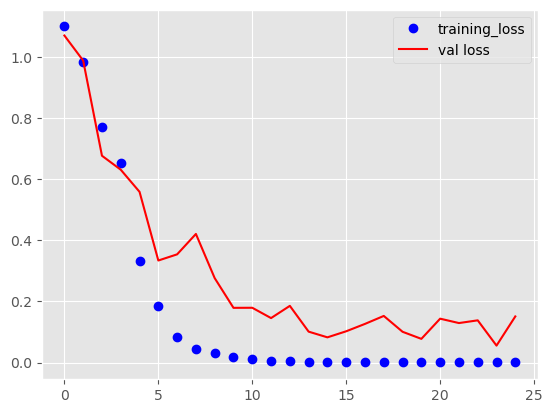

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 4000), (187, 1)
187/187 [==============================] - 13s 64ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7d830c3a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8502673796791443, 'mean': 0.8504385026738037, 'med': 0.8502673796791443, 'q1': 0.8020053475935829, 'q3': 0.8983957219251337, 'whislo': 0.7700534759358288, 'whishi': 0.9197860962566845}, 'f1 all': {'main': 0.8274319753647331, 'mean': 0.8257409424714932, 'med': 0.8268104932511793, 'q1': 0.7679016668794733, 'q3': 0.8834853915499077, 'whislo': 0.7282665610251818, 'whishi': 0.9125526890790342}, 'recall all': {'main': 0.815752146323255, 'mean': 0.8152449240114241, 'med': 0.8154754653622733, 'q1': 0.7657251278971253, 'q3': 0.8680638440860214, 'whislo': 0.7415032679738562, 'whishi': 0.8970370370370371}, 'precision all': {'main': 0.8957125603864734, 'mean': 0.8956151865650095, 'med': 0.8977512802539089, 'q1': 0.8469488534114582, 'q3': 0.9349469287546789, 'whislo': 0.8275424192665572, 'whishi': 0.9565217391304347}, 'naive roc auc': {'main': 0.8769230769230769, 'mean': 0.8769595619617732, 'med': 0.8773571752297049, 'q1': 0.8358168751107878, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7d82cb790>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	22:17:10
	Energy:	2.575258536292 kWh
	CO2eq:	1223.247804738696 g
	This is equivalent to:
	11.379049346406 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1132264_2023-10-08T230352Z_carbontracker_output.log

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7d80a5660>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 75, 75, 3)]    0         
                     

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7b28d5ea0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

10/10 [==============================] - 59s 7s/step - loss: 0.7150 - acc: 0.3719 - f1_m: 0.3719 - val_loss: 0.7256 - val_acc: 0.2578 - val_f1_m: 0.2578
Epoch 16/25
10/10 [==============================] - 59s 7s/step - loss: 0.7078 -

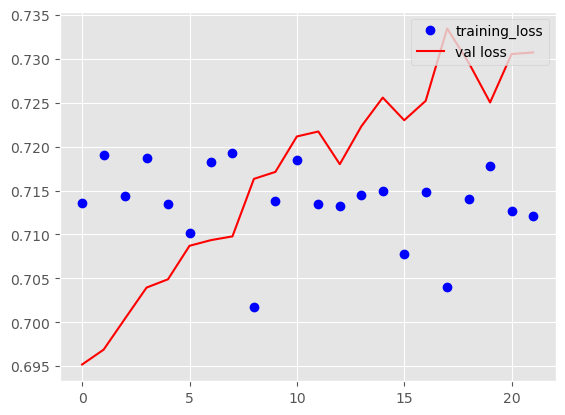

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 4000), (187, 1)
187/187 [==============================] - 13s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7b275c280>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.25133689839572193, 'mean': 0.2524919786096261, 'med': 0.25133689839572193, 'q1': 0.1925133689839572, 'q3': 0.3155080213903743, 'whislo': 0.16042780748663102, 'whishi': 0.3582887700534759}, 'f1 all': {'main': 0.20085470085470084, 'mean': 0.20107014146206625, 'med': 0.20085470085470084, 'q1': 0.16143497757847536, 'q3': 0.23983739837398374, 'whislo': 0.1382488479262673, 'whishi': 0.2637795275590551}, 'recall all': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}, 'precision all': {'main': 0.12566844919786097, 'mean': 0.12624598930481304, 'med': 0.12566844919786097, 'q1': 0.0962566844919786, 'q3': 0.15775401069518716, 'whislo': 0.08021390374331551, 'whishi': 0.17914438502673796}, 'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}, 'balanced accuracy': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc7b28d6fe0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

In [11]:
model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model_cnn2d_scalo('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_cnn2d_scalo('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 2 resistance classification : R et S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [12]:
display(df_res_mabsc_espece)
display(df_res_mabsc_resistance) #We are not keeping this one as the batch size was not set correctly

,all
Metrics,
Test accuracy,0.85
,"[0.8,0.9]"
Test balanced accuracy,0.81
,"[0.77,0.87]"
Mean F1 score,0.82
,"[0.77,0.88]"
F1 score by categories,[0.87 0.65 0.97]
Mean precision,0.89
,"[0.85,0.93]"


,all
Metrics,
Test accuracy,0.25
,"[0.19,0.32]"
Test balanced accuracy,0.50
,"[0.5,0.5]"
Mean F1 score,0.20
,"[0.16,0.24]"
F1 score by categories,[0. 0.4]
Mean precision,0.12
,"[0.1,0.16]"


# CNN2D Scalogram

DATA :  Anophele_identif


2023-10-08 20:36:34.093759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11464 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6a04c9e830>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

2023-10-08 20:36:41.198083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 20:36:44.138233: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6938272290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 20:36:44.138278: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-08 20:36:44.147041: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 20:36:44.305065: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - 87s 7s/step - loss: 4.8929 - categorical_accuracy: 0.3633 - f1_m: 0.3346 - val_loss: 2.0898 - val_categorical_accuracy: 0.2188 - val_f1_m: 0.2187
Epoch 2/25
12/12 [==============================] - 83s 8s/step - loss: 1.2775 - categorical_accuracy: 0.4128 - f1_m: 0.3281 - val_loss: 1.1756 - val_categorical_accuracy: 0.7396 - val_f1_m: 0.0000e+00
Epoch 3/25
12/12 [==============================] - 74s 7s/step - loss: 1.0146 - categorical_accuracy: 0.5977 - f1_m: 0.3773 - val_loss: 1.2028 - val_categorical_accuracy: 0.6771 - val_f1_m: 0.2838
Epoch 4/25
12/12 [==============================] - 73s 7s/step - loss: 0.8980 - categorical_accuracy: 0.6823 - f1_m: 0.4933 - val_loss: 1.1407 - val_categorical_accuracy: 0.6927 - val_f1_m: 0.6773
Epoch 5/25
12/12 [==============================] - 67s 6s/step - loss: 0.8088 - categorical_accuracy: 0.6875 - f1_m: 0.6870 - val_loss: 1.0621 - val_categorical_accuracy: 0.7083 - val_f1_m: 0.7050
Epoch 6/25
12/12 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6950799360>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

12/12 [==============================] - 80s 7s/step - loss: 0.3149 - categorical_accuracy: 0.9036 - f1_m: 0.8990 - val_loss: 0.6673 - val_categorical_accuracy: 0.7604 - val_f1_m: 0.7682
Epoch 13/25
12/12 [==============================] - 75s 7s/step - loss: 0.2327 - categorical_accuracy: 0.9414 - f1_m: 0.9369 - val_loss: 0.6707 - val_categorical_accuracy: 0.7552 - val_f1_m: 0.7574
Epoch 14/25
12/12 [==============================] - 73s 7s/step - loss: 0.1995 - categorical_accuracy: 0.9492 - f1_m: 0.9399 - val_loss: 0.6461 - val_categorical_accuracy: 0.7812 - val_f1_m: 0.7822
Epoch 15/25
12/12 [=============

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6950799c60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

7/7 [==============================] - 28s 5s/step - loss: 0.7571 - categorical_accuracy: 0.8036 - f1_m: 0.7995


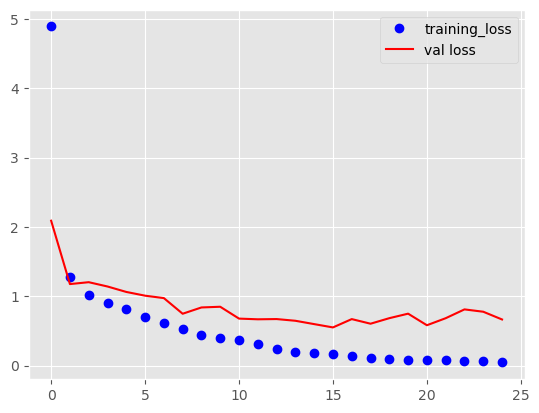

188/188 [==============================] - 12s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6a04bf8e80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.898936170212766, 'mean': 0.8989095744680841, 'med': 0.898936170212766, 'q1': 0.851063829787234, 'q3': 0.9414893617021277, 'whislo': 0.824468085106383, 'whishi': 0.973404255319149}, 'f1 all': {'main': 0.7871598287056223, 'mean': 0.7813114029620998, 'med': 0.7822110478630417, 'q1': 0.6818901958623913, 'q3': 0.8732606128299552, 'whislo': 0.57260101010101, 'whishi': 0.9200828157349896}, 'recall all': {'main': 0.75, 'mean': 0.7498824755555645, 'med': 0.7482008340059187, 'q1': 0.6552401774492789, 'q3': 0.8471215364575341, 'whislo': 0.5678571428571428, 'whishi': 0.9067118226600985}, 'precision all': {'main': 0.8681592039800995, 'mean': 0.8686322720275004, 'med': 0.8691268934085441, 'q1': 0.8068724208079047, 'q3': 0.9292763157894737, 'whislo': 0.5668776371308016, 'whishi': 0.9540441176470589}, 'naive roc auc': {'main': 0.9487060998151571, 'mean': 0.9489880483582874, 'med': 0.9496183807780045, 'q1': 0.9238805410436264, 'q3': 0.971102862

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6a04bf9420>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	27:34:17
	Energy:	3.147992708495 kWh
	CO2eq:	1495.296536535290 g
	This is equivalent to:
	13.909735223584 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1111590_2023-10-08T203634Z_carbontracker_output.log

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f69502a85b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6926f378e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

13/13 [==============================] - 77s 6s/step - loss: 0.0805 - categorical_accuracy: 0.9748 - f1_m: 0.9771 - val_loss: 0.4353 - val_categorical_accuracy: 0.8958 - val_f1_m: 0.9023
Epoch 13/25
13/13 [============================

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6926f58d60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

13/13 [==============================] - 79s 7s/step - loss: 0.0113 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.3764 - val_categorical_accuracy: 0.9219 - val_f1_m: 0.9267
Epoch 24/25
13/13 [============================

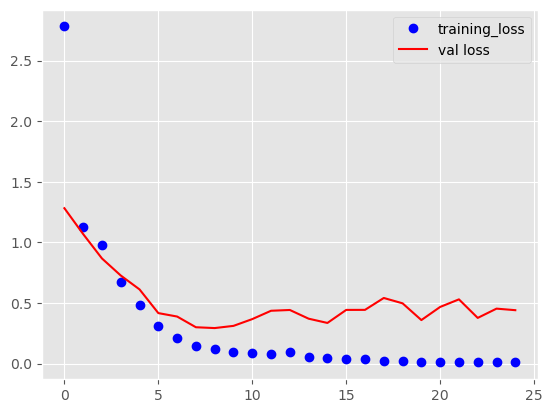

214/214 [==============================] - 14s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6926ff0370>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.8317757009345794, 'mean': 0.8324906542056071, 'med': 0.8317757009345794, 'q1': 0.780373831775701, 'q3': 0.8785046728971962, 'whislo': 0.7476635514018691, 'whishi': 0.9158878504672897}, 'f1 all': {'main': 0.8383769948810599, 'mean': 0.8378995243695508, 'med': 0.8378285836214903, 'q1': 0.7916238054903626, 'q3': 0.8829514997352121, 'whislo': 0.7488894057385492, 'whishi': 0.9113372093023255}, 'recall all': {'main': 0.8379790940766549, 'mean': 0.8386566175460709, 'med': 0.8387059307635129, 'q1': 0.7919946139132186, 'q3': 0.8823884732288987, 'whislo': 0.7563165905631659, 'whishi': 0.9172794117647058}, 'precision all': {'main': 0.8390243902439024, 'mean': 0.8394088756213626, 'med': 0.8394864811636139, 'q1': 0.7920587434527412, 'q3': 0.8854704301075268, 'whislo': 0.7621405953484267, 'whishi': 0.9071859903381643}, 'naive roc auc': {'main': 0.9041807322773305, 'mean': 0.9049481475589306, 'med': 0.9056327341680662, 'q1': 0.8715153348129469,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6926fb9930>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6926f66920>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO -

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6914b0b1f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f69005fb250>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

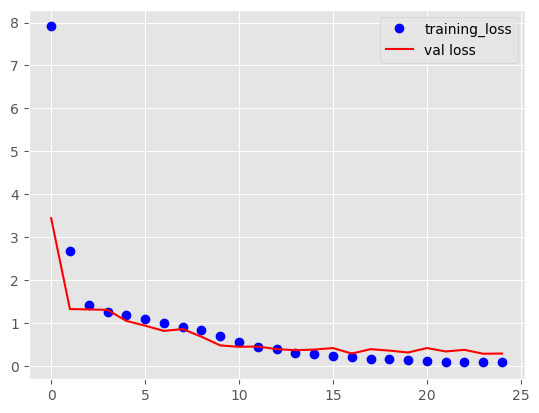

279/279 [==============================] - 18s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6900d9bb50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.8817204301075269, 'mean': 0.8815842293906823, 'med': 0.8817204301075269, 'q1': 0.8457885304659498, 'q3': 0.9175627240143369, 'whislo': 0.8100358422939068, 'whishi': 0.9354838709677419}, 'f1 all': {'main': 0.8538442324659394, 'mean': 0.8518701376532299, 'med': 0.8526059369365266, 'q1': 0.7978814086274417, 'q3': 0.898823834188571, 'whislo': 0.714446126306791, 'whishi': 0.9203139561039879}, 'recall all': {'main': 0.8344191919191919, 'mean': 0.8337855681421594, 'med': 0.8348627236187344, 'q1': 0.7706244074724631, 'q3': 0.889804139434355, 'whislo': 0.7114652214717166, 'whishi': 0.9202897205393786}, 'precision all': {'main': 0.8842623063211299, 'mean': 0.8845544304267927, 'med': 0.8844048997225216, 'q1': 0.85037237417207, 'q3': 0.9200044412335388, 'whislo': 0.8276846915460776, 'whishi': 0.9364935587761674}, 'naive roc auc': {'main': 0.9090309200603318, 'mean': 0.9093923591867865, 'med': 0.9099654053387144, 'q1': 0.8752533960837613, '

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f690065add0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f690065b1c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO -

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6900d38640>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

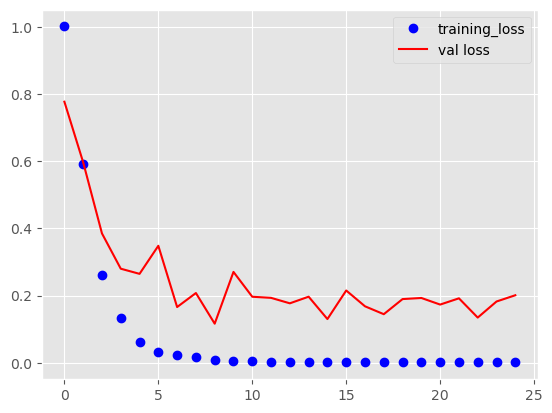

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 4000), (187, 1)
187/187 [==============================] - 12s 64ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6900bc8c10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8021390374331551, 'mean': 0.8031069518716568, 'med': 0.8021390374331551, 'q1': 0.7433155080213903, 'q3': 0.8609625668449198, 'whislo': 0.7005347593582888, 'whishi': 0.893048128342246}, 'f1 all': {'main': 0.7333496305953933, 'mean': 0.7330732434666621, 'med': 0.7317407366976361, 'q1': 0.6664549420004798, 'q3': 0.801966400772694, 'whislo': 0.6221681059610181, 'whishi': 0.8537199234873653}, 'recall all': {'main': 0.7369582348305753, 'mean': 0.7378408416098373, 'med': 0.7369489522653045, 'q1': 0.6910597943722944, 'q3': 0.7863306315433974, 'whislo': 0.663220551378446, 'whishi': 0.8255813953488372}, 'precision all': {'main': 0.8904055724075947, 'mean': 0.8909975936779393, 'med': 0.8916385716936099, 'q1': 0.8541919191919191, 'q3': 0.9255900086132643, 'whislo': 0.8324707686409814, 'whishi': 0.9452736318407959}, 'naive roc auc': {'main': 0.8395670198065408, 'mean': 0.8395892774329883, 'med': 0.8401683532703457, 'q1': 0.7937478381884032, 'q

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6900bca2c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [8]:
model_choice = 'cnn_2d_for_scalogram_timedistributed'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d_scalo('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D scalogram",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model_cnn2d_scalo('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCU RACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [9]:
display(df_res_anophele_ident) #Need Rerunning for legs due to an incorrect batch size
display(df_res_mabsc_espece)

,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.89,0.83,0.88
,"[0.85,0.94]","[0.78,0.88]","[0.85,0.92]"
Test balanced accuracy,0.75,0.83,0.83
,"[0.66,0.85]","[0.79,0.88]","[0.77,0.89]"
Mean F1 score,0.78,0.83,0.85
,"[0.68,0.87]","[0.79,0.88]","[0.8,0.9]"
F1 score by categories,[1. 0.85 0.67 0.63],[0.99 0.78 1. 0.59],[0.95 0.9 0.86 0.71]
Mean precision,0.86,0.83,0.88
,"[0.81,0.93]","[0.79,0.89]","[0.85,0.92]"


,all
Metrics,
Test accuracy,0.80
,"[0.74,0.86]"
Test balanced accuracy,0.73
,"[0.69,0.79]"
Mean F1 score,0.73
,"[0.67,0.8]"
F1 score by categories,[0.85 0.41 0.95]
Mean precision,0.89
,"[0.85,0.93]"


DATA :  Anophele_identif
Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f61a41ecb80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


_________________________________________________________________
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 75, 75, 3)]    0         
                                                                 
 time_distributed (TimeDist  (None, 9, 73, 73, 3)      84        
 ributed)                                                        
                       

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6159591420>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

12/12 [==============================] - 73s 7s/step - loss: 0.1446 - categorical_accuracy: 0.9740 - f1_m: 0.9723 - val_loss: 0.5476 - val_categorical_accuracy: 0.8542 - val_f1_m: 0.8450
Epoch 14/25
12/12 [============================

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f61595918a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

7/7 [==============================] - 28s 5s/step - loss: 0.6076 - categorical_accuracy: 0.8705 - f1_m: 0.8737


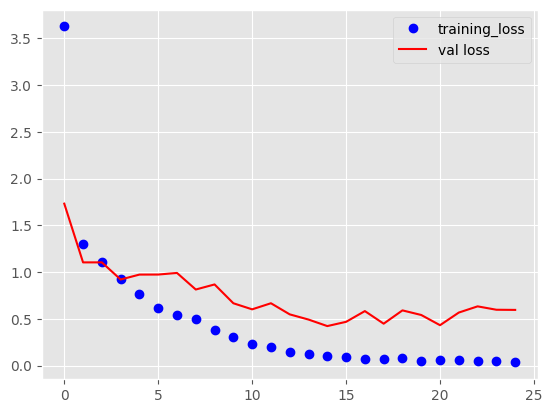

188/188 [==============================] - 12s 63ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f615a55d390>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.925531914893617, 'mean': 0.9256063829787222, 'med': 0.925531914893617, 'q1': 0.8881648936170213, 'q3': 0.9574468085106383, 'whislo': 0.8563829787234043, 'whishi': 0.9840425531914894}, 'f1 all': {'main': 0.8826543044284979, 'mean': 0.8799454005832045, 'med': 0.8809940983542464, 'q1': 0.8217448224491503, 'q3': 0.9326678312970286, 'whislo': 0.7822823210561524, 'whishi': 0.9610576923076923}, 'recall all': {'main': 0.8766156462585034, 'mean': 0.8757398365092903, 'med': 0.8760196987582576, 'q1': 0.8166624040920716, 'q3': 0.9303793337510442, 'whislo': 0.7808080808080808, 'whishi': 0.9610576923076923}, 'precision all': {'main': 0.8913143382352942, 'mean': 0.8906072713616794, 'med': 0.8909557547715442, 'q1': 0.8278618841701441, 'q3': 0.947349671763929, 'whislo': 0.79296875, 'whishi': 0.9872881355932204}, 'naive roc auc': {'main': 0.958271719038817, 'mean': 0.9586405639922991, 'med': 0.9592650333903021, 'q1': 0.9336142845448128, 'q3': 0.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f615a55e9e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

In [21]:
model_choice = 'cnn_2d_for_scalogram_timedistributed'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d_scalo('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D scalogram",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [22]:
display(df_res_anophele_ident) #Rerunning for legs due to an incorrect batch size in the previous run
#we keep this one

,PATTES
Metrics,
Test accuracy,0.92
,"[0.89,0.96]"
Test balanced accuracy,0.87
,"[0.82,0.93]"
Mean F1 score,0.88
,"[0.82,0.93]"
F1 score by categories,[0.99 0.89 1. 0.65]
Mean precision,0.89
,"[0.83,0.95]"


2023-10-08 18:55:15.297119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f20597c24a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 2, 4, 5, 7, 8, 9, 11, 14, 16, 19, 21, 22, 23, 24, 25, 27, 28, 31, 3, 6, 10, 13, 15, 17, 30, 32] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Val label :  [18, 20, 26, 29, 1, 12] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 1, 1]
Train data dimensions: (648, 4000), (648, 1)
Validation data dimensions: (166, 4000), (166, 1)
Model: "model"
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)   

2023-10-08 18:55:22.940496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 18:55:24.856220: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f203c17d0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 18:55:24.856255: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-08 18:55:24.864986: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 18:55:25.008796: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 73s 7s/step - loss: 1.2676 - acc: 0.4344 - f1_m: 0.4344 - val_loss: 0.8473 - val_acc: 0.2812 - val_f1_m: 0.2812
Epoch 2/25
10/10 [==============================] - 60s 7s/step - loss: 0.7370 - acc: 0.5656 - f1_m: 0.5656 - val_loss: 0.7056 - val_acc: 0.2500 - val_f1_m: 0.2500
Epoch 3/25
10/10 [==============================] - 59s 7s/step - loss: 0.7062 - acc: 0.3531 - f1_m: 0.3531 - val_loss: 0.8377 - val_acc: 0.2500 - val_f1_m: 0.2500
Epoch 4/25
10/10 [==============================] - 60s 7s/step - loss: 0.7090 - acc: 0.3562 - f1_m: 0.3562 - val_loss: 0.7089 - val_acc: 0.2422 - val_f1_m: 0.2422
Epoch 5/25
10/10 [==============================] - 60s 7s/step - loss: 0.7168 - acc: 0.4406 - f1_m: 0.4406 - val_loss: 0.6981 - val_acc: 0.2578 - val_f1_m: 0.2578
Epoch 6/25
10/10 [==============================] - 60s 7s/step - loss: 0.7133 - acc: 0.3750 - f1_m: 0.3750 - val_loss: 0.8008 - val_acc: 0.2500 - val_f1_m: 0.2500
Epoch 7/25
10/10 [=========

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f205046c610>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

10/10 [==============================] - 59s 7s/step - loss: 0.4172 - acc: 0.8297 - f1_m: 0.8297 - val_loss: 0.6351 - val_acc: 0.5625 - val_f1_m: 0.5625
Epoch 16/25
10/10 [==============================] - 59s 7s/step - loss: 0.2063 - acc: 0.9484 - f1_m: 0.9484 - val_loss: 0.7869 - val_acc: 0.5859 - val_f1_m: 0.5859
Epoch 17/25
10/10 [==============================] - 60s 7s/step - loss: 0.1044 - acc: 0.9688 - f1_m: 0.9688 - val_loss: 1.3258 - val_acc: 0.5469 - val_f1_m: 0.5469
Epoch 18/25
10/10 [==============================] - 60s 7s/step - loss: 0.0639 - acc: 0.9766 - f1_m: 0.9766 - val_loss: 1.2803 - val_

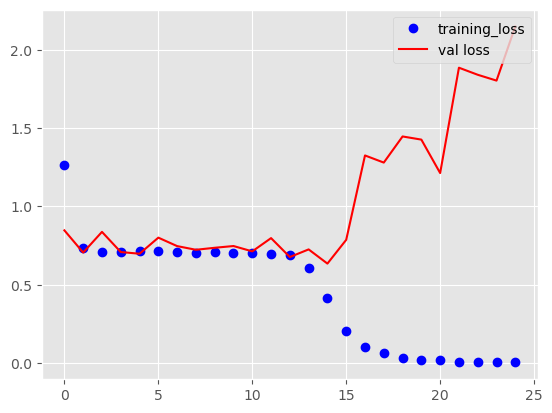

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 4000), (187, 1)
187/187 [==============================] - 12s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f20502286a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.7647058823529411, 'mean': 0.7638342245989276, 'med': 0.7647058823529411, 'q1': 0.7058823529411765, 'q3': 0.8183155080213903, 'whislo': 0.6684491978609626, 'whishi': 0.8609625668449198}, 'f1 all': {'main': 0.7457983193277311, 'mean': 0.7437479180409146, 'med': 0.7425063968542229, 'q1': 0.6797927993928541, 'q3': 0.8064870034035119, 'whislo': 0.6348782242318364, 'whishi': 0.841855321363518}, 'recall all': {'main': 0.835790273556231, 'mean': 0.8353245838749256, 'med': 0.835828144688075, 'q1': 0.7911853401291115, 'q3': 0.8750068157033806, 'whislo': 0.7583724569640062, 'whishi': 0.902027027027027}, 'precision all': {'main': 0.7533249254758083, 'mean': 0.7525758412052933, 'med': 0.7526881720430108, 'q1': 0.7009803921568627, 'q3': 0.804887676508344, 'whislo': 0.6525157232704403, 'whishi': 0.8333333333333333}, 'naive roc auc': {'main': 0.835790273556231, 'mean': 0.8353245838749257, 'med': 0.835828144688075, 'q1': 0.7911853401291115, 'q3': 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f20502286d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	22:16:41
	Energy:	2.504289026040 kWh
	CO2eq:	1189.537287369057 g
	This is equivalent to:
	11.065463138317 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1096735_2023-10-08T185515Z_carbontracker_output.log

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f205046d300>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
 Layer (type)                Output Shape             

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2026f702b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

12/12 [==============================] - 73s 7s/step - loss: 0.4459 - categorical_accuracy: 0.8659 - f1_m: 0.8602 - val_loss: 0.6443 - val_categorical_accuracy: 0.7656 - val_f1_m: 0.7646
Epoch 13/25
12/12 [============================

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2026f706d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

7/7 [==============================] - 28s 5s/step - loss: 0.6508 - categorical_accuracy: 0.8348 - f1_m: 0.8341


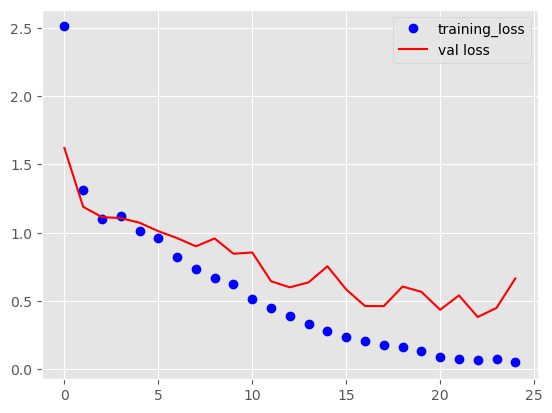

188/188 [==============================] - 12s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2014b22fb0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.9574468085106383, 'mean': 0.9579521276595748, 'med': 0.9574468085106383, 'q1': 0.925531914893617, 'q3': 0.9840425531914894, 'whislo': 0.9095744680851063, 'whishi': 1.0}, 'f1 all': {'main': 0.921875, 'mean': 0.922264669975903, 'med': 0.92297103767692, 'q1': 0.8703340675075469, 'q3': 0.9706372804227704, 'whislo': 0.8245192307692307, 'whishi': 1.0}, 'recall all': {'main': 0.9, 'mean': 0.9023595352308965, 'med': 0.9021739130434783, 'q1': 0.8472222222222222, 'q3': 0.9583333333333334, 'whislo': 0.8076923076923077, 'whishi': 1.0}, 'precision all': {'main': 0.9705882352941176, 'mean': 0.9708575048667012, 'med': 0.9710144927536232, 'q1': 0.9516098940779971, 'q3': 0.9894366197183099, 'whislo': 0.9423076923076923, 'whishi': 1.0}, 'naive roc auc': {'main': 0.9704251386321626, 'mean': 0.9709911363635416, 'med': 0.971272456363104, 'q1': 0.9520273953800108, 'q3': 0.9888374820159812, 'whislo': 0.938561696990601, 'whishi': 1.0}, 'balanced accur

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2014b34b20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2026f72830>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (mos

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f20005f77c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f200061c550>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

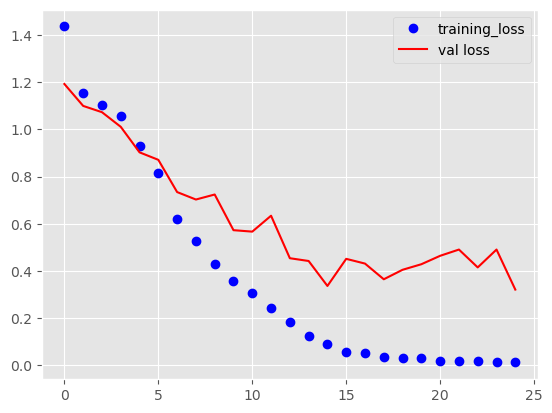

214/214 [==============================] - 14s 64ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2000dab370>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.8271028037383178, 'mean': 0.8278971962616813, 'med': 0.8271028037383178, 'q1': 0.7710280373831776, 'q3': 0.8738317757009346, 'whislo': 0.7429906542056075, 'whishi': 0.897196261682243}, 'f1 all': {'main': 0.8345558815684182, 'mean': 0.8343361001485351, 'med': 0.8344261906622272, 'q1': 0.7892470104818895, 'q3': 0.8762164843743078, 'whislo': 0.7627825555712204, 'whishi': 0.9064559151939566}, 'recall all': {'main': 0.8349303135888502, 'mean': 0.83565583887354, 'med': 0.8356513278388278, 'q1': 0.7899428342033272, 'q3': 0.8774211178032285, 'whislo': 0.76659891598916, 'whishi': 0.9026027397260274}, 'precision all': {'main': 0.8342151675485008, 'mean': 0.8352148950277271, 'med': 0.8354788642658386, 'q1': 0.7892182787379471, 'q3': 0.8783315363235576, 'whislo': 0.7636604233094719, 'whishi': 0.9140295358649789}, 'naive roc auc': {'main': 0.9021682679823423, 'mean': 0.9026882280374546, 'med': 0.9037974867505545, 'q1': 0.8681236913497254, 'q3

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2000da8160>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f200064bdf0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
 

KeyboardInterrupt: 

In [8]:
model_choice = 'cnn_2d_for_scalogram_timedistributed'
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_cnn2d_scalo('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 2 resistance classification : R et S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d_scalo('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D scalogram",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [9]:
display(df_res_mabsc_resistance)
display(df_res_anophele_ident)

,all
Metrics,
Test accuracy,0.76
,"[0.71,0.82]"
Test balanced accuracy,0.83
,"[0.79,0.88]"
Mean F1 score,0.74
,"[0.68,0.81]"
F1 score by categories,[0.82 0.68]
Mean precision,0.75
,"[0.7,0.8]"


NameError: name 'df_res_anophele_ident' is not defined

DATA :  Anophele_age


2025-02-01 12:23:42.999281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0ae7467910>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10

2025-02-01 12:23:49.098583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-02-01 12:23:51.440565: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e106528800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-01 12:23:51.440616: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2025-02-01 12:23:51.449195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-01 12:23:51.600239: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 72s 7s/step - loss: 8.3225 - mae: 8.8120 - val_loss: 7.4170 - val_mae: 7.9147
Epoch 2/25
10/10 [==============================] - 59s 7s/step - loss: 7.0703 - mae: 7.5593 - val_loss: 6.9539 - val_mae: 7.4539
Epoch 3/25
10/10 [==============================] - 59s 7s/step - loss: 6.8227 - mae: 7.3114 - val_loss: 6.4322 - val_mae: 6.9322
Epoch 4/25
10/10 [==============================] - 59s 7s/step - loss: 6.2061 - mae: 6.6997 - val_loss: 6.2781 - val_mae: 6.7504
Epoch 5/25
10/10 [==============================] - 59s 7s/step - loss: 6.0786 - mae: 6.5702 - val_loss: 6.2924 - val_mae: 6.7717
Epoch 6/25
10/10 [==============================] - 58s 6s/step - loss: 5.5108 - mae: 5.9967 - val_loss: 5.0920 - val_mae: 5.5919
Epoch 7/25
10/10 [==============================] - 62s 7s/step - loss: 4.4826 - mae: 4.9638 - val_loss: 4.6707 - val_mae: 5.1610
Epoch 8/25
10/10 [==============================] - 56s 6s/step - loss: 4.2111 - mae: 4.6908 - val_lo

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0a301e0160>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

10/10 [==============================] - 59s 7s/step - loss: 2.1598 - mae: 2.5715 - val_loss: 2.5985 - val_mae: 3.0402
Epoch 16/25
10/10 [==============================] - 59s 7s/step - loss: 2.0194 - mae: 2.4317 - val_loss: 2.1259 - val_mae: 2.5592
Epoch 17/25
10/10 [==============================] - 59s 7s/step - loss: 1.9786 - mae: 2.3910 - val_loss: 2.1178 - val_mae: 2.5277
Epoch 18/25
10/10 [==============================] - 61s 7s/step - loss: 1.6985 - mae: 2.0919 - val_loss: 2.3464 - val_mae: 2.7769
Epoch 19/25
10/10 [==============================] - 56s 6s/step - loss: 1.6456 - mae: 2.0526 - val_loss:

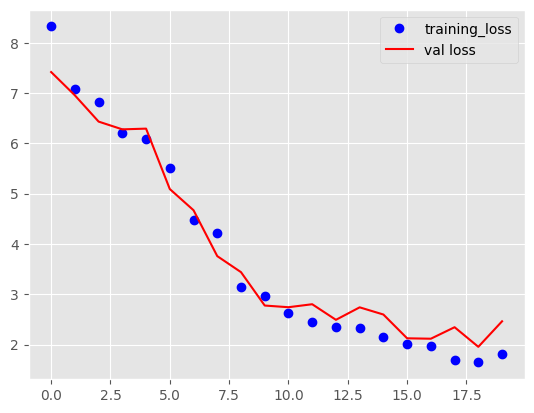

144/144 [==============================] - 9s 63ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.22303721,  2.4567466 ,  0.        ,
        0.        ,  0.        

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0a17f812a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.643475, 'mean': 8.643965, 'med': 8.591689, 'q1': 6.837534308433533, 'q3': 10.499376130104064, 'whislo': 5.684169, 'whishi': 12.06504}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:21:26
	Energy:	0.040571319329 kWh
	CO2eq:	19.271376681276 g
	This is equivalent to:
	0.179268620291 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0a17f814e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	17:51:26
	Energy:	2.028565966450 kWh
	CO2eq:	963.568834063780 g
	This is equivalent to:
	8.963431014547 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/3308402_2025-01-31T234838Z_carbontracker_output.log
S

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0a3012c400>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 75, 75, 3)]    0         
                     

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09f4ba2830>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

9/9 [==============================] - 55s 7s/step - loss: 1.6978 - mae: 2.0948 - val_loss: 2.9446 - val_mae: 3.3773
Epoch 18/25
9/9 [==============================] - 55s 7s/step - loss: 1.7091 - mae: 2.0956 - val_loss: 2.6017 - val_

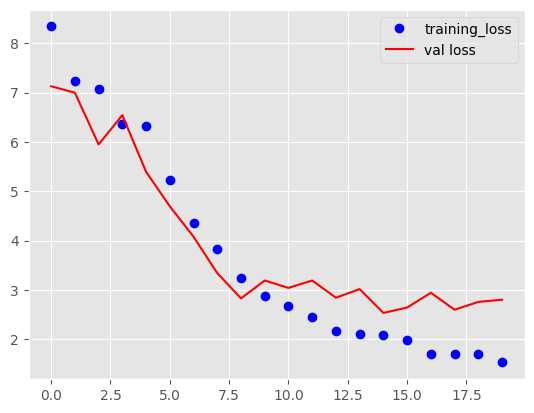

124/124 [==============================] - 9s 64ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 0.99028856,  3.1254494 ,  0.42256728,  0.        ,  1.60952   ,
        0.66679245,  9.024375  ,  2.315155  ,  2.727755  ,  3.3103583 ,
        2.3751087 ,  3.8941371 ,  4.692192  ,  5.3593044 ,  5.9472547 ,
 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09f4bf1c60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.623292, 'mean': 8.614311, 'med': 8.626005, 'q1': 7.325911867618561, 'q3': 9.906633567810058, 'whislo': 6.5256643, 'whishi': 11.217971}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracke

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09f4bf3910>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09e350c5e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_____________________

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09e2cec790>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

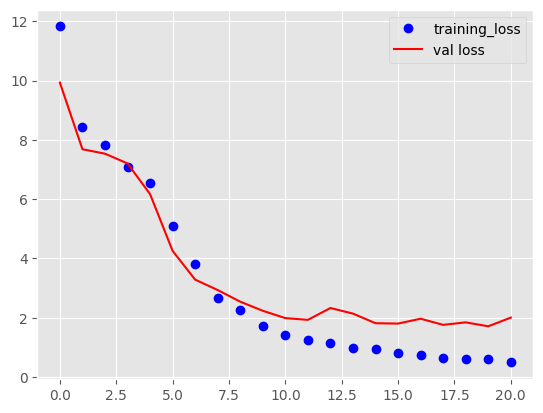

117/117 [==============================] - 10s 64ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.       ,  0.       ,  0.       ,  0.1085522,  0.       ,
        0.       ,  0.       ,  0.       ,  7.674804 ,  3.3600116,
        6.502573 ,  4.185503 ,  4.448526 ,  2.3483505,  2.74075  ,
        4.133683 ,  3.9205818,  6.9299297,  3.93307

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09e3426ef0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 7.780868, 'mean': 7.810954, 'med': 7.775936, 'q1': 6.3924602508544925, 'q3': 9.318651866912841, 'whislo': 5.0121355, 'whishi': 10.476725}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontrac

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09e3426260>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [10]:
model_choice = 'cnn_2d_for_scalogram_timedistributed'

TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_cnn2d_scalo('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Senegal 1", position = 0)


In [11]:
display(df_res_anophele_pauline)

,P,T,TH
Metrics,,,
Test MAE,3.01,3.10,2.26
,"[2.64,3.44]","[2.66,3.56]","[1.91,2.65]"
Roc AUC score,0.89,0.90,0.95
,"[0.86,0.92]","[0.87,0.93]","[0.93,0.97]"
R2 score,0.75,0.77,0.87


# CNN2D Hybrid Scalogram - Anopheles species

2023-06-23 00:26:32.103059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-23 00:26:32.103096: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-23 00:26:32.103494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train label :  [37, 41, 42, 43, 45, 46, 47, 49, 50, 51, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 165, 166, 168, 169, 170, 171, 172, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 195, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 0, 1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 52, 53, 54, 56, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 58, 59, 134, 60, 62, 63, 64, 67, 68, 69, 70, 72, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 159, 160, 162, 163, 164] size :  172
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

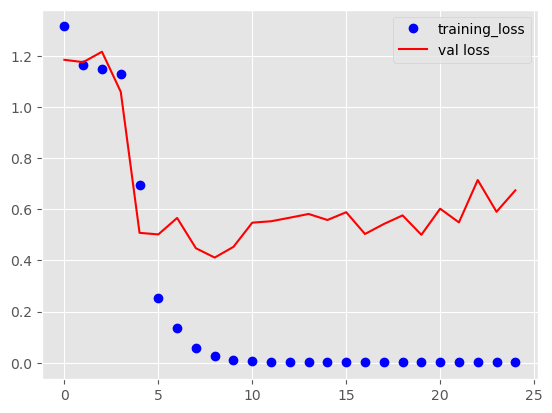

214/214 [==============================] - 15s 66ms/step
pred :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
test pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 

In [6]:
model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d_scalo('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D Hybrid scalogram",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [7]:
display(df_res_anophele_ident) #This run is kept as the previous one failed due to a training interruption

,TETE
Metrics,
Test accuracy,0.81
,"[0.76,0.87]"
Test balanced accuracy,0.81
,"[0.77,0.87]"
Mean F1 score,0.82
,"[0.77,0.87]"
F1 score by categories,[0.95 0.76 1. 0.59]
Mean precision,0.83
,"[0.78,0.89]"


2023-06-22 21:03:31.638717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-22 21:03:31.638746: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-22 21:03:31.639049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

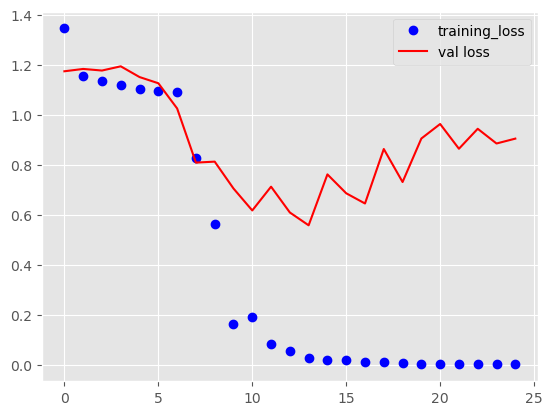

188/188 [==============================] - 13s 66ms/step
pred :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
test pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 1
 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

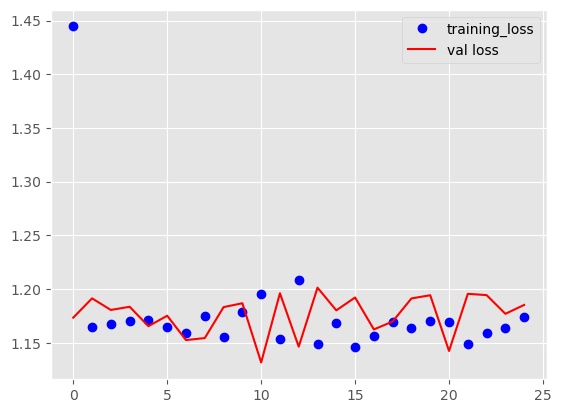

214/214 [==============================] - 15s 67ms/step
pred :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
test pred :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

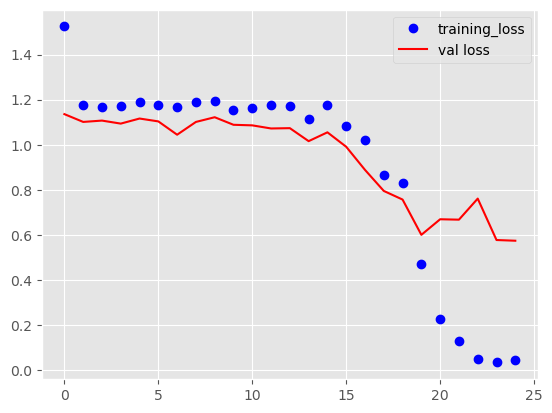

279/279 [==============================] - 19s 65ms/step
pred :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
test pred :  [0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [6]:
model_choice = 'cnn_2d_BiGRU_for_scalogram_timedistributed'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d_scalo('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D Hybrid scalogram",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [7]:
display(df_res_anophele_ident) 
#we do not keep head part as we had power interruption during execution that why we have this result

,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.90,0.37,0.91
,"[0.87,0.95]","[0.31,0.44]","[0.89,0.95]"
Test balanced accuracy,0.86,0.25,0.90
,"[0.81,0.92]","[0.25,0.25]","[0.87,0.94]"
Mean F1 score,0.87,0.13,0.90
,"[0.81,0.92]","[0.12,0.15]","[0.87,0.94]"
F1 score by categories,[0.98 0.86 1. 0.65],[0.54 0. 0. 0. ],[0.98 0.89 0.98 0.79]
Mean precision,0.88,0.09,0.92
,"[0.82,0.94]","[0.08,0.11]","[0.88,0.95]"


# CNN 2 dimension - Fourier

In [9]:
#len_sp = 4000
def run_model_cnn2d(data_name, model_name):
    
    if data_name == 'MABSC_coh_espece':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_basl_interp_5'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        feature_of_stratification = 'souche'
        colonne = 'spectrogram'
        target = 'espece'
        number_class = 3
        EPOCH = 50
        BATCH = 32
        types = 'classification'

        start = timeit.default_timer()
        
        data_train[colonne] = transform_spectrogram(data_train['Intensite baseline als interp reduc 5'], colonne, width=128, height=128, choose_rgb = False)
        data_test[colonne] = transform_spectrogram(data_test['Intensite baseline als interp reduc 5'], colonne, width=128, height=128,choose_rgb = False)
        

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()

        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_espece = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_espece)

        bootstrap_collect_espece = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_espece)

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")


        essaie.clean_model_session()
        return tableau_perf_espece, bootstrap_collect_espece
    
    
        
    elif data_name == 'MABSC_coh_resistance':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_basl_interp_5'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        data_train['resistance'] = data_train.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        data_test['resistance'] = data_test.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        feature_of_stratification = 'souche'
        colonne = 'spectrogram'
        target = 'resistance'
        number_class = 2
        EPOCH = 50
        BATCH = 16
        types = 'classification'

        start = timeit.default_timer()
        
        data_train[colonne] = transform_spectrogram(data_train['Intensite baseline als interp reduc 5'], colonne,width=128, height=128, choose_rgb = False)
        data_test[colonne] = transform_spectrogram(data_test['Intensite baseline als interp reduc 5'], colonne, width=128, height=128, choose_rgb = False)


        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()

        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_resistance = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_resistance)
        
        bootstrap_collect_resistance = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_resistance)

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")


        essaie.clean_model_session()
        
        return tableau_perf_resistance, bootstrap_collect_resistance
    
    
    elif data_name == 'Anophele_age':
        print("DATA : ", data_name )
        type_data_name = 'Intensite_basl_interp_5'
        data_train, test_pauline, test_noemie = more_data_uploading(data_name, type_data_name)
        
        data_train['regression'] = data_train.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_pauline['regression'] = test_pauline.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_noemie['regression'] = test_noemie.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        
        data_train['Partie anatomique'] = data_train.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_pauline['Partie anatomique'] = test_pauline.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_noemie['Partie anatomique'] = test_noemie.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'spectrogram'
        target = 'regression'
        number_class = 1
        EPOCH = 50
        BATCH = 32
        types = 'regression'
        
        data_train[colonne] = transform_spectrogram(data_train['Intensite baseline als interp reduc 5'], colonne,width=128, height=128, choose_rgb = False)
        test_pauline[colonne] = transform_spectrogram(test_pauline['Intensite baseline als interp reduc 5'], colonne, width=128, height=128, choose_rgb = False)
        test_noemie[colonne] = transform_spectrogram(test_noemie['Intensite baseline als interp reduc 5'], colonne, width=128, height=128, choose_rgb = False)

        
        tableau_perf_pauline_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_pauline_all = collections.defaultdict(list)
        tableau_perf_noemie_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_noemie_all = collections.defaultdict(list)

        for part_anatom in ['P', 'T', 'TH']:
            
            train = data_train[data_train['Partie anatomique']==part_anatom]
            train = train.reset_index(drop=True)

            tst_pauline = test_pauline[test_pauline['Partie anatomique']==part_anatom]
            tst_pauline = tst_pauline.reset_index(drop=True)
            tst_noemie = test_noemie[test_noemie['Partie anatomique']==part_anatom]
            tst_noemie = tst_noemie.reset_index(drop=True)

            start = timeit.default_timer()

            essaie = Methodology_models(model_name, len_sp, number_class)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data_pauline, y_tst_data_pauline = essaie.data_preparation_zero_shot_test(tst_pauline, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            tst_data_noemie, y_tst_data_noemie = essaie.data_preparation_zero_shot_test(tst_noemie, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            del train, tst_pauline, tst_noemie

            
            tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
            tracker.epoch_start()


            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test_pauline = essaie.model_predict(tst_data_pauline, y_tst_data_pauline, types)
            tableau_perf_pauline = performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(tableau_perf_pauline)
            for el, el_update in zip(tableau_perf_pauline, tableau_perf_pauline_all):
                el_update.update(el)
            
            bootstrap_collect_pauline = bootstrap_performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(bootstrap_collect_pauline)
            bootstrap_collect_pauline_all.update(bootstrap_collect_pauline)

            essaie_compile_y_test_noemie = essaie.model_predict(tst_data_noemie, y_tst_data_noemie, types)
            tableau_perf_noemie = performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(tableau_perf_noemie)
            for el, el_update in zip(tableau_perf_noemie, tableau_perf_noemie_all):
                el_update.update(el)
            
            bootstrap_collect_noemie = bootstrap_performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(bootstrap_collect_noemie)
            bootstrap_collect_noemie_all.update(bootstrap_collect_noemie)

            tracker.epoch_end()
            tracker.stop()
            
            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]
            
            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
            
            
            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")
            
            print("#######################################################################################")
            
            stop = timeit.default_timer()
    
            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")
    
                
            essaie.clean_model_session()

            del tr_data, y_tr_data, va_data, y_va_data, tst_data_pauline, y_tst_data_pauline, tst_data_noemie, y_tst_data_noemie
            
        
        return tableau_perf_pauline_all, bootstrap_collect_pauline_all, tableau_perf_noemie_all, bootstrap_collect_noemie_all
    
    
    elif data_name == 'Anophele_identif':
        print("DATA : ", data_name )
        type_data_name = 'Intensite_basl_interp_5'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        
        data_train = data_train[~data_train.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        data_test = data_test[~data_test.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'spectrogram'
        target = 'espece'
        number_class = 4
        EPOCH = 50
        BATCH = 32
        types = 'classification'

        start = timeit.default_timer()
        
        data_train[colonne] = transform_spectrogram(data_train['Intensite baseline als interp reduc 5'], colonne, width=128, height=128, choose_rgb = False)
        data_test[colonne] = transform_spectrogram(data_test['Intensite baseline als interp reduc 5'], colonne, width=128, height=128, choose_rgb = False)
        
        
        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)

        for part_anatom in ['PATTES', 'TETE', 'THORAX']:
            train = data_train[data_train['anatom']==part_anatom] 
            train = train.reset_index(drop=True)

            tst = data_test[data_test['anatom']==part_anatom] 
            tst = tst.reset_index(drop=True)

            essaie = Methodology_models(model_name, len_sp, number_class)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(tst, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)


            del train, tst

            
            tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
            tracker.epoch_start()


            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)
            
            tableau_perf = performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(tableau_perf)
            for el, el_update in zip(tableau_perf, tableau_perf_all):
                el_update.update(el)
        
            bootstrap_collect = bootstrap_performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(bootstrap_collect)
            bootstrap_collect_all.update(bootstrap_collect)

            tracker.epoch_end()
            tracker.stop()
            
            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]
            
            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
            
            
            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")
            
            print("#######################################################################################")
            
            stop = timeit.default_timer()
    
            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")


            essaie.clean_model_session()
            
            del tr_data, y_tr_data, va_data, y_va_data, tst_data, y_tst_data
            
            
        return tableau_perf_all, bootstrap_collect_all
    
    
    
    else :
        raise ValueError("Data name unknown")
        

### CNN2D Hybrid

DATA :  MABSC_coh_espece


2025-01-30 20:28:23.940417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11601 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 128, 128), (680, 1)
Validation data dimensions: (134, 128, 128), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f10104ebdf0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)     

2025-01-30 20:28:31.931093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-01-30 20:28:33.881291: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0fa42906a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-30 20:28:33.881331: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2025-01-30 20:28:33.887183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-30 20:28:33.985004: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 12s 62ms/step - loss: 1.1193 - categorical_accuracy: 0.2857 - f1_m: 0.0151 - val_loss: 1.1080 - val_categorical_accuracy: 0.3125 - val_f1_m: 0.0000e+00
Epoch 2/50
21/21 [==============================] - 0s 22ms/step - loss: 1.0956 - categorical_accuracy: 0.4435 - f1_m: 0.0000e+00 - val_loss: 1.0851 - val_categorical_accuracy: 0.5078 - val_f1_m: 0.0000e+00
Epoch 3/50
21/21 [==============================] - 0s 22ms/step - loss: 1.0905 - categorical_accuracy: 0.3482 - f1_m: 0.0029 - val_loss: 0.9218 - val_categorical_accuracy: 0.4375 - val_f1_m: 0.2092
Epoch 4/50
21/21 [==============================] - 0s 23ms/step - loss: 0.9397 - categorical_accuracy: 0.6488 - f1_m: 0.4746 - val_loss: 0.9138 - val_categorical_accuracy: 0.7031 - val_f1_m: 0.3503
Epoch 5/50
21/21 [==============================] - 0s 23ms/step - loss: 0.7236 - categorical_accuracy: 0.7426 - f1_m: 0.7212 - val_loss: 0.6457 - val_categorical_accuracy: 0.7812 - val_f1_m: 0.8092
Epo

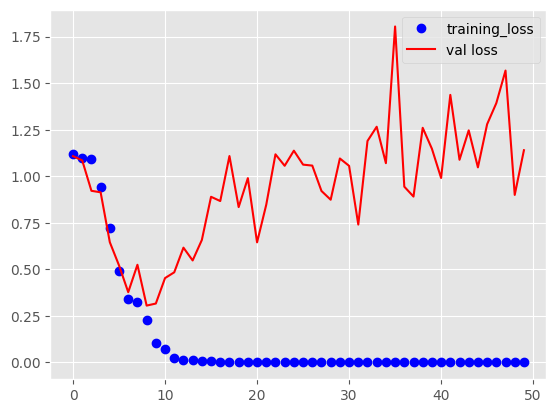

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 128, 128), (187, 1)
187/187 [==============================] - 1s 3ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f101026c7f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.6363636363636364, 'mean': 0.6356577540106951, 'med': 0.6363636363636364, 'q1': 0.5668449197860963, 'q3': 0.7058823529411765, 'whislo': 0.45989304812834225, 'whishi': 0.7433155080213903}, 'f1 all': {'main': 0.4915555555555556, 'mean': 0.49024319163950886, 'med': 0.4916265767030404, 'q1': 0.43876791411959865, 'q3': 0.5375467121483889, 'whislo': 0.37435150972268877, 'whishi': 0.567965367965368}, 'recall all': {'main': 0.5267056530214425, 'mean': 0.52664405260189, 'med': 0.527111042552219, 'q1': 0.47422500607618906, 'q3': 0.5742023794711365, 'whislo': 0.4466165413533834, 'whishi': 0.6055806938159879}, 'precision all': {'main': 0.5068100358422939, 'mean': 0.5062804260328291, 'med': 0.506862292947651, 'q1': 0.4618044042882405, 'q3': 0.5445578679311556, 'whislo': 0.408724399290437, 'whishi': 0.5641025641025641}, 'naive roc auc': {'main': 0.668770152003685, 'mean': 0.6681211016742188, 'med': 0.6679536452692423, 'q1': 0.6102616856981424, '

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f101026e530>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	1:15:22
	Energy:	0.174066888224 kWh
	CO2eq:	82.681771906185 g
	This is equivalent to:
	0.769132761918 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/3090547_2025-01-30T202824Z_carbontracker_output.log
Sta

In [11]:
model_choice = 'cnn_2d_version_2_BiGRU'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model_cnn2d('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [12]:
#30/01/25
display(df_res_mabsc_espece)

,all
Metrics,
Test accuracy,0.63
,"[0.57,0.71]"
Test balanced accuracy,0.52
,"[0.47,0.57]"
Mean F1 score,0.49
,"[0.44,0.54]"
F1 score by categories,[0.73 0. 0.75]
Mean precision,0.50
,"[0.46,0.54]"


DATA :  MABSC_coh_resistance
Train label :  [0, 2, 4, 5, 7, 8, 9, 11, 14, 16, 19, 21, 22, 23, 24, 25, 27, 28, 31, 3, 6, 10, 13, 15, 17, 30, 32] size :  27
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Val label :  [18, 20, 26, 29, 1, 12] size :  6
Y val label :  [0, 0, 0, 0, 1, 1]
Train data dimensions: (648, 128, 128), (648, 1)
Validation data dimensions: (166, 128, 128), (166, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f76105b6b60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (mos

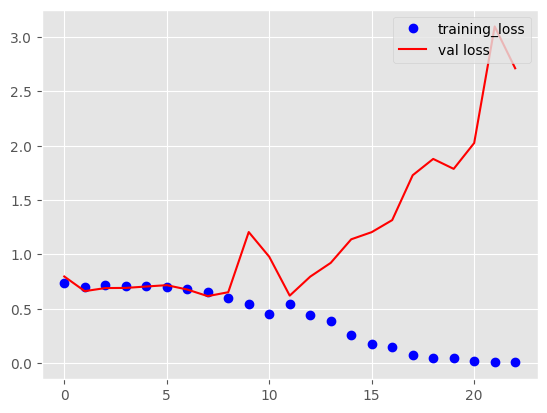

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test label :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 128, 128), (187, 1)
187/187 [==============================] - 1s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f761157cc10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.7540106951871658, 'mean': 0.7542566844919782, 'med': 0.7540106951871658, 'q1': 0.6898395721925134, 'q3': 0.8129679144385026, 'whislo': 0.6631016042780749, 'whishi': 0.8502673796791443}, 'f1 all': {'main': 0.45028118609406953, 'mean': 0.4488279071939461, 'med': 0.4456767555634783, 'q1': 0.41562499999999997, 'q3': 0.5011386557355716, 'whislo': 0.3987138263665595, 'whishi': 0.5621212121212121}, 'recall all': {'main': 0.5106382978723404, 'mean': 0.5101462105505538, 'med': 0.51, 'q1': 0.5, 'q3': 0.5348837209302325, 'whislo': 0.5, 'whishi': 0.5686274509803921}, 'precision all': {'main': 0.8763440860215054, 'mean': 0.6809965303453469, 'med': 0.8614130434782609, 'q1': 0.35561497326203206, 'q3': 0.9032258064516129, 'whislo': 0.3315508021390374, 'whishi': 0.924731182795699}, 'naive roc auc': {'main': 0.5106382978723404, 'mean': 0.5101462105505538, 'med': 0.51, 'q1': 0.5, 'q3': 0.5348837209302325, 'whislo': 0.5, 'whishi': 0.5686274509803921}

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f761157cd60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [13]:
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_cnn2d('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 resistance classification : R (et RIND), S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [14]:
#30/01/25
display(df_res_mabsc_resistance)

,all
Metrics,
Test accuracy,0.75
,"[0.69,0.81]"
Test balanced accuracy,0.51
,"[0.5,0.53]"
Mean F1 score,0.45
,"[0.42,0.5]"
F1 score by categories,[0.86 0.04]
Mean precision,0.87
,"[0.36,0.9]"


In [12]:
model_choice = 'cnn_2d_version_2_BiGRU'

DATA :  Anophele_age


2025-01-30 21:41:10.953711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11601 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c8dd1d8d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)     

2025-01-30 21:41:14.813624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-01-30 21:41:16.399845: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0bd076dc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-30 21:41:16.399886: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2025-01-30 21:41:16.405615: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-30 21:41:16.501454: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - 10s 57ms/step - loss: 7.3907 - mae: 7.8766 - val_loss: 8.0079 - val_mae: 8.4915
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 7.1456 - mae: 7.6371 - val_loss: 6.8710 - val_mae: 7.3521
Epoch 3/50
20/20 [==============================] - 0s 22ms/step - loss: 7.0215 - mae: 7.5116 - val_loss: 6.5848 - val_mae: 7.0814
Epoch 4/50
20/20 [==============================] - 0s 21ms/step - loss: 6.8010 - mae: 7.2909 - val_loss: 6.8266 - val_mae: 7.3159
Epoch 5/50
20/20 [==============================] - 0s 22ms/step - loss: 6.6586 - mae: 7.1436 - val_loss: 7.0605 - val_mae: 7.5453
Epoch 6/50
20/20 [==============================] - 0s 22ms/step - loss: 6.5900 - mae: 7.0764 - val_loss: 6.2528 - val_mae: 6.7467
Epoch 7/50
20/20 [==============================] - 0s 21ms/step - loss: 5.4904 - mae: 5.9648 - val_loss: 4.9863 - val_mae: 5.4612
Epoch 8/50
20/20 [==============================] - 0s 23ms/step - loss: 4.6823 - mae: 5.1332

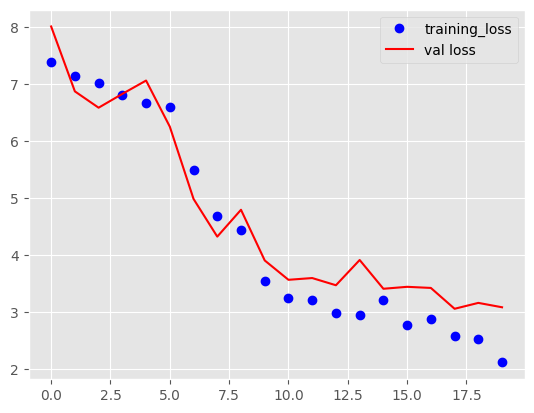

144/144 [==============================] - 1s 3ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.27381653,  0.        ,  0.        ,  0.        ,  6.4831347 ,
        0.11839946,  4.306766  ,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c90e5b1c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.625, 'mean': 0.6230726833602583, 'med': 0.6240525684063543, 'q1': 0.5232008179521738, 'q3': 0.7173596507504536, 'whislo': 0.46339285714285716, 'whishi': 0.7730202578268877}}, {'mae': {'main': 11.91722, 'mean': 11.907912, 'med': 11.860502, 'q1': 9.500612902641297, 'q3': 14.299907279014587, 'whislo': 8.335512, 'whishi': 16.351816}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:48
	Energy:	0.001656668103 kWh
	CO2eq:	0.78

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c90e5b1f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:39:57
	Energy:	0.082833405133 kWh
	CO2eq:	39.345867438153 g
	This is equivalent to:
	0.366008069192 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/3096719_2025-01-30T214014Z_carbontracker_output.log
Sta

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c90e73fd0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                     

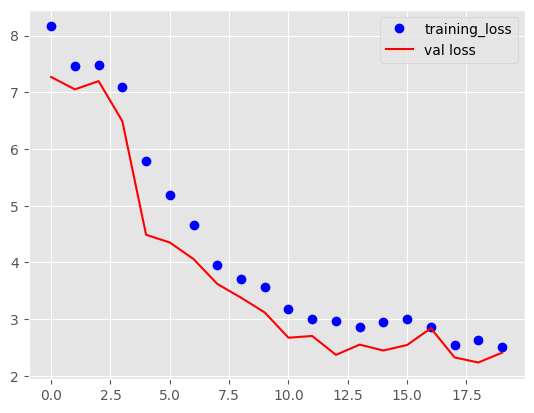

124/124 [==============================] - 1s 3ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 2.0841463 ,  0.        ,  0.671789  ,  0.        ,  0.2008764 ,
        0.20423183,  3.774134  ,  0.        ,  6.2415032 ,  4.111975  ,
        3.5086846 ,  4.8396378 ,  0.        ,  0.        ,  0.        ,
  

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c38dc4b80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 10.122656, 'mean': 10.133396, 'med': 10.110962, 'q1': 7.78896416425705, 'q3': 12.379271626472473, 'whislo': 5.812885, 'whishi': 13.76351}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontrack

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c38dc5330>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c4cb5d330>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)     

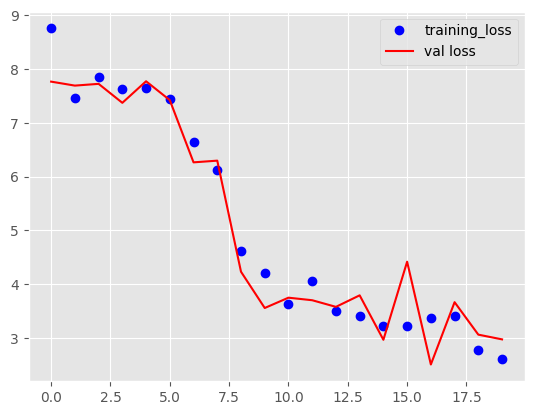

117/117 [==============================] - 1s 3ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.        ,  0.        ,  5.772637  ,
        5.562274  ,  6.8427577 ,  2.4119208 ,  3.6415071 ,  5.20136   ,
        7.5618534 ,  7.382147  ,  7.268876  ,  5.4072747 ,  3.3592458 ,
        4.4109745 ,  3.6678653 ,  4.29

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c39da1a50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 12.384615, 'mean': 12.349577, 'med': 12.288462, 'q1': 9.903365015983582, 'q3': 14.924038171768188, 'whislo': 7.8461537, 'whishi': 16.75}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontrack

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c39da1b10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [13]:
TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_cnn2d('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Senegal 1", position = 0)

In [14]:
#30/01/25
display(df_res_anophele_pauline)

,P,T,TH
Metrics,,,
Test MAE,3.15,3.22,3.76
,"[2.69,3.61]","[2.82,3.66]","[3.11,4.44]"
Roc AUC score,0.87,0.90,0.85
,"[0.83,0.91]","[0.87,0.93]","[0.8,0.9]"
R2 score,0.69,0.77,0.63


DATA :  Anophele_identif


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c386ddae0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train label :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

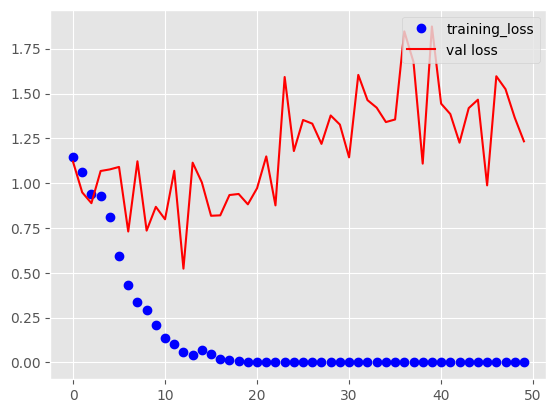

188/188 [==============================] - 1s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0bfb950310>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.9468085106382979, 'mean': 0.9469680851063825, 'med': 0.9468085106382979, 'q1': 0.9148936170212766, 'q3': 0.973404255319149, 'whislo': 0.8829787234042553, 'whishi': 0.9946808510638298}, 'f1 all': {'main': 0.9177458475845571, 'mean': 0.9158930365635946, 'med': 0.9180904735797828, 'q1': 0.863060465439166, 'q3': 0.9607748824665125, 'whislo': 0.8343153654740803, 'whishi': 0.9896832316187154}, 'recall all': {'main': 0.9099489795918367, 'mean': 0.9092414356002855, 'med': 0.9110674353598882, 'q1': 0.8557462891069157, 'q3': 0.9581867444747852, 'whislo': 0.8291903409090909, 'whishi': 0.9927413273001509}, 'precision all': {'main': 0.9285386029411764, 'mean': 0.9285306006458307, 'med': 0.9307529335071708, 'q1': 0.871696767416644, 'q3': 0.9759779884493842, 'whislo': 0.8295114656031904, 'whishi': 0.9955357142857143}, 'naive roc auc': {'main': 0.9693622920517561, 'mean': 0.9695458126323037, 'med': 0.9707030276023558, 'q1': 0.9496789721863741,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0bfb9504c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c39df8df0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_nos

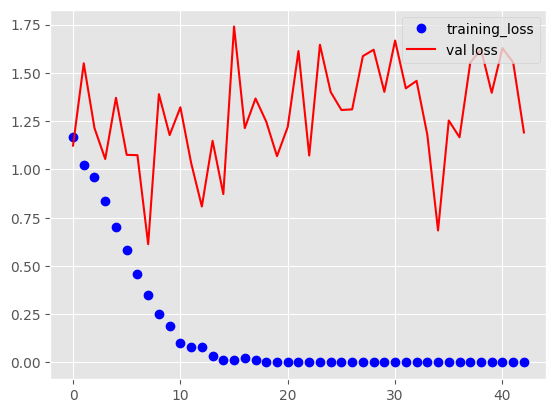

214/214 [==============================] - 1s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c394d0d30>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.8411214953271028, 'mean': 0.8422897196261688, 'med': 0.8411214953271028, 'q1': 0.794392523364486, 'q3': 0.8925233644859814, 'whislo': 0.7616822429906542, 'whishi': 0.9299065420560748}, 'f1 all': {'main': 0.850334527229098, 'mean': 0.85050120374312, 'med': 0.8505456390427572, 'q1': 0.8043184454538034, 'q3': 0.8956247595633597, 'whislo': 0.7578509681438433, 'whishi': 0.9327660498785113}, 'recall all': {'main': 0.8440766550522647, 'mean': 0.8453432951625998, 'med': 0.8447076297686054, 'q1': 0.8017452781237028, 'q3': 0.891125182726581, 'whislo': 0.7636572742955723, 'whishi': 0.9277167792792793}, 'precision all': {'main': 0.8687574671445639, 'mean': 0.8696461064867708, 'med': 0.870347949152297, 'q1': 0.8246412419019681, 'q3': 0.9163304560849012, 'whislo': 0.7840893817204302, 'whishi': 0.9411127289253972}, 'naive roc auc': {'main': 0.8930148013502986, 'mean': 0.8941168805534819, 'med': 0.8937791318371628, 'q1': 0.8599443124640861, 'q3'

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c394d0bb0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0c39b675b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
 

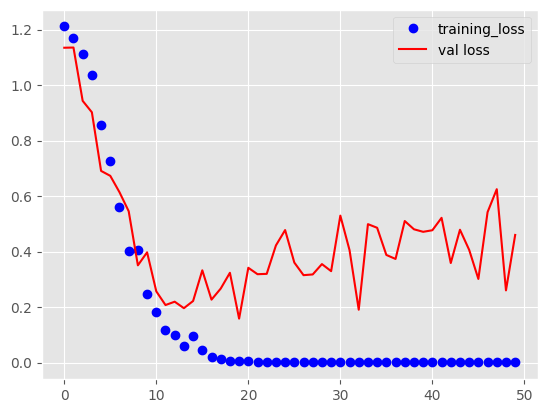

279/279 [==============================] - 1s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0bfbcf5210>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.8781362007168458, 'mean': 0.8783870967741946, 'med': 0.8781362007168458, 'q1': 0.8351254480286738, 'q3': 0.9139784946236559, 'whislo': 0.8136200716845878, 'whishi': 0.942652329749104}, 'f1 all': {'main': 0.8533150564063781, 'mean': 0.8520576817087888, 'med': 0.8529963093776681, 'q1': 0.7938027325202475, 'q3': 0.8998360436483435, 'whislo': 0.7469167053277843, 'whishi': 0.9279838914256723}, 'recall all': {'main': 0.8235353535353536, 'mean': 0.8239956823364553, 'med': 0.8254610991351795, 'q1': 0.7558424961871618, 'q3': 0.8801272439879291, 'whislo': 0.7164590669781389, 'whishi': 0.9071865081820834}, 'precision all': {'main': 0.9095647488755623, 'mean': 0.9099242661299433, 'med': 0.9114448725729213, 'q1': 0.8729076119860498, 'q3': 0.9414149171802775, 'whislo': 0.8204118909764071, 'whishi': 0.9595985273492287}, 'naive roc auc': {'main': 0.8874622926093514, 'mean': 0.887482512687091, 'med': 0.8878266857741042, 'q1': 0.8481121974997606

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0bfbcf6530>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [16]:
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D version 2",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [17]:
#30/01/25
display(df_res_anophele_ident)

,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.94,0.84,0.87
,"[0.91,0.97]","[0.79,0.89]","[0.84,0.91]"
Test balanced accuracy,0.90,0.84,0.82
,"[0.86,0.96]","[0.8,0.89]","[0.76,0.88]"
Mean F1 score,0.91,0.85,0.85
,"[0.86,0.96]","[0.8,0.9]","[0.79,0.9]"
F1 score by categories,[0.99 0.92 1. 0.76],[0.92 0.81 1. 0.67],[0.93 0.88 0.89 0.71]
Mean precision,0.92,0.86,0.90
,"[0.87,0.98]","[0.82,0.92]","[0.87,0.94]"


### CNN2D

2023-10-07 23:30:21.749577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b02eff40>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 128, 128), (680, 1)
Validation data dimensions: (134, 128, 128), (134, 1)
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
_________________________________________________________________
 Layer (

2023-10-07 23:30:23.933526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-07 23:30:25.195480: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f01a41fb6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 23:30:25.195511: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-07 23:30:25.200845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 23:30:25.300150: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 5s 28ms/step - loss: 1.2951 - categorical_accuracy: 0.4360 - f1_m: 0.1295 - val_loss: 1.0719 - val_categorical_accuracy: 0.6016 - val_f1_m: 0.0000e+00
Epoch 2/50
21/21 [==============================] - 0s 15ms/step - loss: 1.1432 - categorical_accuracy: 0.2545 - f1_m: 0.0134 - val_loss: 1.0889 - val_categorical_accuracy: 0.5938 - val_f1_m: 0.0000e+00
Epoch 3/50
21/21 [==============================] - 0s 16ms/step - loss: 0.9916 - categorical_accuracy: 0.5446 - f1_m: 0.1158 - val_loss: 0.8884 - val_categorical_accuracy: 0.5547 - val_f1_m: 0.5981
Epoch 4/50
21/21 [==============================] - 0s 16ms/step - loss: 0.8311 - categorical_accuracy: 0.7277 - f1_m: 0.5555 - val_loss: 0.5329 - val_categorical_accuracy: 0.8984 - val_f1_m: 0.8326
Epoch 5/50
21/21 [==============================] - 0s 16ms/step - loss: 0.4901 - categorical_accuracy: 0.8661 - f1_m: 0.8394 - val_loss: 0.3038 - val_categorical_accuracy: 0.8984 - val_f1_m: 0.8984
Epoch 6/

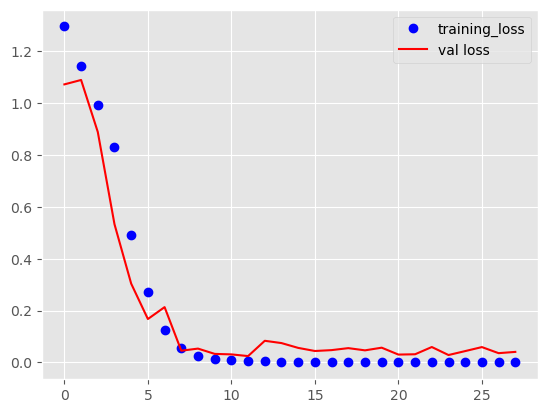

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 128, 128), (187, 1)
187/187 [==============================] - 1s 2ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f018ffb80a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.6524064171122995, 'mean': 0.6517165775401051, 'med': 0.6524064171122995, 'q1': 0.5828877005347594, 'q3': 0.7165775401069518, 'whislo': 0.5294117647058824, 'whishi': 0.7647058823529411}, 'f1 all': {'main': 0.5105069385443217, 'mean': 0.5094835574872114, 'med': 0.510123923686148, 'q1': 0.4661651467490988, 'q3': 0.5482223838455301, 'whislo': 0.43741222446113454, 'whishi': 0.5717855083605613}, 'recall all': {'main': 0.5996101364522417, 'mean': 0.5997531710038945, 'med': 0.6, 'q1': 0.5696818395235624, 'q3': 0.6282689810844292, 'whislo': 0.5485739750445633, 'whishi': 0.6477272727272728}, 'precision all': {'main': 0.4445591397849462, 'mean': 0.44413873506218315, 'med': 0.44497725110967884, 'q1': 0.3934925058316213, 'q3': 0.4919316856226305, 'whislo': 0.356060606060606, 'whishi': 0.5144413608798438}, 'naive roc auc': {'main': 0.7180561953017043, 'mean': 0.7174080766989852, 'med': 0.7182709826056867, 'q1': 0.6549684912081679, 'q3': 0.76936

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f018ffb8d90>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:44:38
	Energy:	0.086384521842 kWh
	CO2eq:	41.032647875162 g
	This is equivalent to:
	0.381699050002 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/932893_2023-10-07T233022Z_carbontracker_output.log
Stan

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b1042e00>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

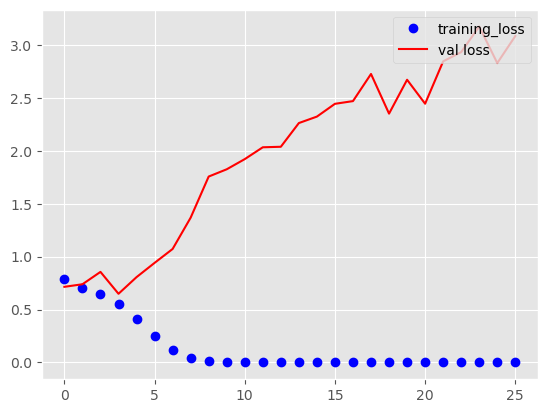

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 128, 128), (187, 1)
187/187 [==============================] - 0s 1ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b1018700>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8074866310160428, 'mean': 0.8071764705882356, 'med': 0.8074866310160428, 'q1': 0.7486631016042781, 'q3': 0.8663101604278075, 'whislo': 0.7058823529411765, 'whishi': 0.9037433155080213}, 'f1 all': {'main': 0.7877679697351829, 'mean': 0.7866968433069048, 'med': 0.7865296803652968, 'q1': 0.7257978972327084, 'q3': 0.8507302989130434, 'whislo': 0.6812335347900201, 'whishi': 0.8988824801730354}, 'recall all': {'main': 0.8714285714285714, 'mean': 0.8710620661414543, 'med': 0.8714285714285714, 'q1': 0.8333035714285714, 'q3': 0.90741452991453, 'whislo': 0.8129251700680272, 'whishi': 0.9268292682926829}, 'precision all': {'main': 0.7831325301204819, 'mean': 0.7833694971570522, 'med': 0.7824808184143222, 'q1': 0.7345581340834505, 'q3': 0.8378596338273757, 'whislo': 0.7066666666666667, 'whishi': 0.8902439024390244}, 'naive roc auc': {'main': 0.8714285714285714, 'mean': 0.8710620661414543, 'med': 0.8714285714285714, 'q1': 0.8333035714285715, '

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b1018e80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b111e1d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

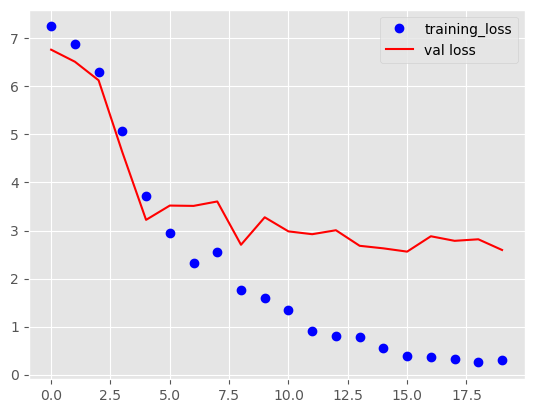

144/144 [==============================] - 0s 1ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 1.2652982 ,  0.        ,  0.09193411,  2.26632   ,  6.789758  ,
        0.        ,  2.8136652 ,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0b12ec0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.572706, 'mean': 8.585008, 'med': 8.613935, 'q1': 7.208605754375458, 'q3': 9.838854908943176, 'whislo': 6.0590086, 'whishi': 10.976553}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracke

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0b130a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0286620>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_nos

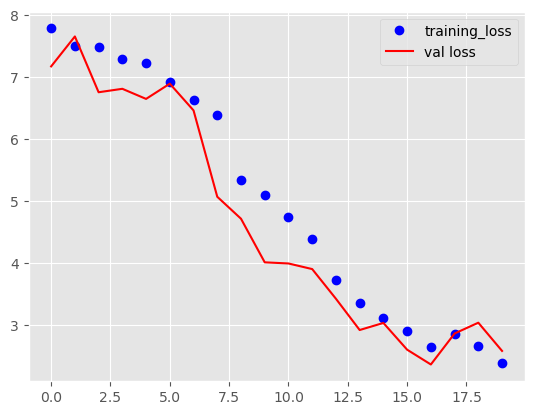

124/124 [==============================] - 0s 1ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 2.859399  ,  3.0470083 ,  2.065667  ,  0.41004026,  2.0827062 ,
        1.6410372 ,  4.468198  ,  0.45860404,  5.077088  ,  3.8965108 ,
        4.3398266 ,  3.8615313 ,  0.22383454,  1.3236713 ,  0.74155617,
  

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0761030>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.294531, 'mean': 8.261795, 'med': 8.257386, 'q1': 7.005971431732178, 'q3': 9.54369649887085, 'whislo': 5.9112325, 'whishi': 10.043215}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0763c40>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0b63970>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/e

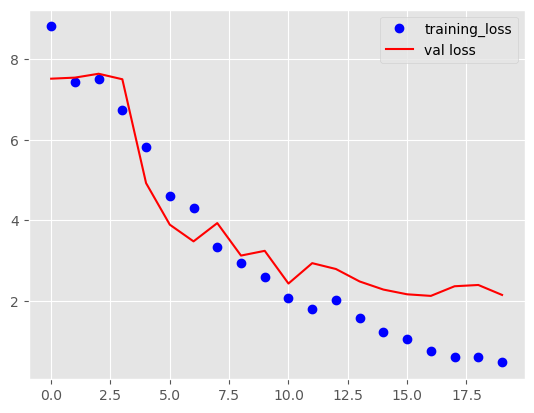

117/117 [==============================] - 0s 1ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.66596127,  0.3509147 ,  0.        ,
        2.5658627 ,  0.37394014,  0.36195302,  4.7469816 ,  4.4673676 ,
        4.8368173 ,  6.808559  ,  4.2343764 ,  4.950227  ,  5.3108606 ,
        3.5551832 ,  7.210431  ,  5.90

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0618880>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 7.8943067, 'mean': 7.882615, 'med': 7.8702316, 'q1': 6.586137688159942, 'q3': 9.163356804847718, 'whislo': 5.745615, 'whishi': 9.913385}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontrack

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0619ff0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0c06950>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

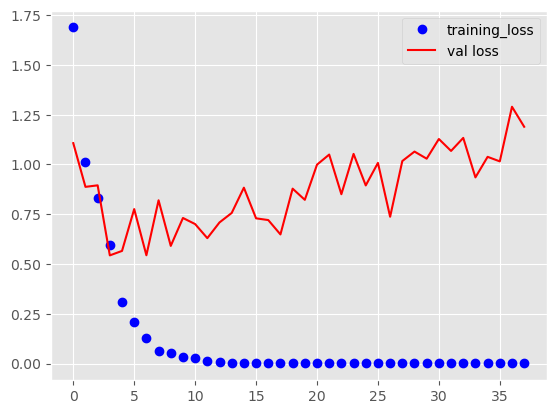

188/188 [==============================] - 0s 1ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0b10880>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.9414893617021277, 'mean': 0.9408457446808501, 'med': 0.9414893617021277, 'q1': 0.9042553191489362, 'q3': 0.9680851063829787, 'whislo': 0.8829787234042553, 'whishi': 0.9893617021276596}, 'f1 all': {'main': 0.9032015527022992, 'mean': 0.8995088268835756, 'med': 0.900948054417334, 'q1': 0.8386950242506183, 'q3': 0.9471195032844634, 'whislo': 0.7962907642519294, 'whishi': 0.9771428571428571}, 'recall all': {'main': 0.8875000000000001, 'mean': 0.8855875507497978, 'med': 0.886533380069025, 'q1': 0.8263823621553884, 'q3': 0.9384708867521367, 'whislo': 0.7923076923076924, 'whishi': 0.9666666666666667}, 'precision all': {'main': 0.930991230991231, 'mean': 0.9295449354325604, 'med': 0.9314050523638852, 'q1': 0.8686445280059936, 'q3': 0.9757204394543092, 'whislo': 0.801486013986014, 'whishi': 0.9916666666666667}, 'naive roc auc': {'main': 0.9625693160813309, 'mean': 0.9623772011428585, 'med': 0.9631777642200783, 'q1': 0.9392254481185754, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0d58d90>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b04b2f20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbon

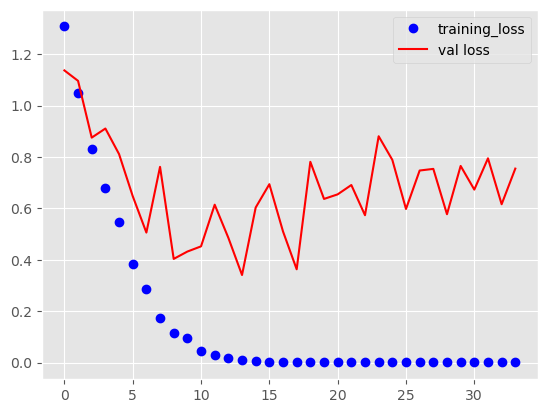

214/214 [==============================] - 0s 1ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0931bd0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.7850467289719626, 'mean': 0.7863691588785044, 'med': 0.7850467289719626, 'q1': 0.7289719626168224, 'q3': 0.8365654205607476, 'whislo': 0.6915887850467289, 'whishi': 0.8691588785046729}, 'f1 all': {'main': 0.8039854679780709, 'mean': 0.8032139825446849, 'med': 0.803730311343926, 'q1': 0.756928639896152, 'q3': 0.8479027062278081, 'whislo': 0.7185608067961009, 'whishi': 0.8692989349478786}, 'recall all': {'main': 0.8074150696864111, 'mean': 0.8076570753289244, 'med': 0.8078081384682971, 'q1': 0.7615095170314973, 'q3': 0.8515666683503762, 'whislo': 0.7215127215127215, 'whishi': 0.8782169117647058}, 'precision all': {'main': 0.8023571887846146, 'mean': 0.8029349894112516, 'med': 0.8035135115088128, 'q1': 0.7550292713314277, 'q3': 0.8478961663400086, 'whislo': 0.7190466772151899, 'whishi': 0.8687930906664689}, 'naive roc auc': {'main': 0.8834393663983381, 'mean': 0.8841620031256305, 'med': 0.8849957778576232, 'q1': 0.8528200357200211, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b0930d00>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b02842b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following compone

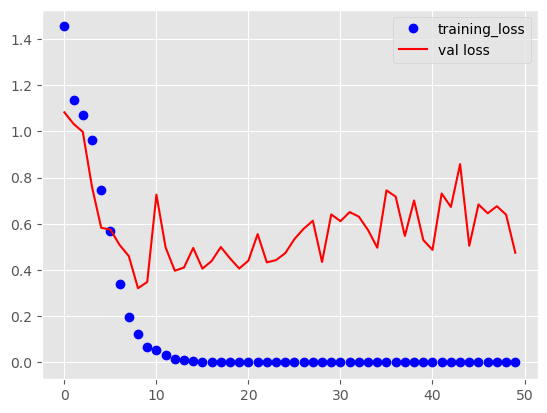

279/279 [==============================] - 0s 1ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b00ebeb0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.9247311827956989, 'mean': 0.9253727598566305, 'med': 0.9247311827956989, 'q1': 0.8924731182795699, 'q3': 0.956989247311828, 'whislo': 0.8709677419354839, 'whishi': 0.96415770609319}, 'f1 all': {'main': 0.9175990154396956, 'mean': 0.9173786035219376, 'med': 0.9175832909615472, 'q1': 0.8821792204496411, 'q3': 0.950860060602677, 'whislo': 0.8589575562052626, 'whishi': 0.9630257873523587}, 'recall all': {'main': 0.9031818181818182, 'mean': 0.9034407158072097, 'med': 0.9033432048561999, 'q1': 0.8687446120689656, 'q3': 0.9375021740210694, 'whislo': 0.8453679931536157, 'whishi': 0.9555073941866394}, 'precision all': {'main': 0.9556683784624961, 'mean': 0.9560198985519036, 'med': 0.9560843715693533, 'q1': 0.9383119631642179, 'q3': 0.9734571495109454, 'whislo': 0.9306332512866413, 'whishi': 0.9784022622834924}, 'naive roc auc': {'main': 0.9422699849170437, 'mean': 0.9426078335032069, 'med': 0.9429872016313449, 'q1': 0.9179259873232644, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f01b00e8940>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [7]:
model_choice = 'cnn_2d_version_2'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model_cnn2d('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_cnn2d('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 resistance classification : R (et RIND), S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_cnn2d('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Pauline", position = 0)

TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n  = tableau_perf_noemie
TEST_BOOTSTRAP_n = bootstrap_collect_noemie
df_res_anophele_noemie = show_table_results_regression(TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n,TEST_BOOTSTRAP_n,
                                                       "Anophele Noémie", position = 0)

del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_cnn2d('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN2D version 2",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [8]:
#07/10/23
display(df_res_mabsc_espece)
display(df_res_mabsc_resistance)
display(df_res_anophele_pauline)
display(df_res_anophele_noemie) #we do not keep this one
display(df_res_anophele_ident)

,all
Metrics,
Test accuracy,0.65
,"[0.58,0.72]"
Test balanced accuracy,0.59
,"[0.57,0.63]"
Mean F1 score,0.51
,"[0.47,0.55]"
F1 score by categories,[0.71 0. 0.82]
Mean precision,0.44
,"[0.39,0.49]"


,all
Metrics,
Test accuracy,0.80
,"[0.75,0.87]"
Test balanced accuracy,0.87
,"[0.83,0.91]"
Mean F1 score,0.78
,"[0.73,0.85]"
F1 score by categories,[0.85 0.72]
Mean precision,0.78
,"[0.73,0.84]"


,P,T,TH
Metrics,,,
Test MAE,2.60,3.24,2.86
,"[2.26,2.95]","[2.79,3.71]","[2.47,3.27]"
Roc AUC score,0.92,0.89,0.92
,"[0.9,0.94]","[0.86,0.92]","[0.9,0.95]"
R2 score,0.82,0.75,0.82


,P,T,TH
Metrics,,,
Test MAE,8.57,8.29,7.89
,"[7.21,9.84]","[7.01,9.54]","[6.59,9.16]"
Roc AUC score,0.50,0.50,0.50
,"[0.5,0.5]","[0.5,0.5]","[0.5,0.5]"
R2 score,-0.16,-0.14,0.00


,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.94,0.78,0.92
,"[0.9,0.97]","[0.73,0.84]","[0.89,0.96]"
Test balanced accuracy,0.88,0.80,0.90
,"[0.83,0.94]","[0.76,0.85]","[0.87,0.94]"
Mean F1 score,0.90,0.80,0.91
,"[0.84,0.95]","[0.76,0.85]","[0.88,0.95]"
F1 score by categories,[0.99 0.91 1. 0.71],[0.95 0.71 1. 0.56],[0.98 0.91 1. 0.78]
Mean precision,0.93,0.80,0.95
,"[0.87,0.98]","[0.76,0.85]","[0.94,0.97]"
